In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset


    #train multiple classifiers
    for T in tasks:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
            test_index = test_index[task_inds]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)

            s+=1

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [3]:
folder_path = r'Z:CIS-PD Study'
subjects_path = r'Z:\CIS-PD Study\Subjects' #Windows remote path
dict_path = 'Z:\CIS-PD Study\Data_dict'
scores_path = r'Z:\CIS-PD Study\Scores' #remote repo
features_path = r'Z:\CIS-PD Study\FeatureMatrix' #remote repo
#results_path = r'C:\Users\andre\Documents\GitHub\CIS_PD\Results' #results folder
results_path = r'C:\Users\LU-RT&O\Documents\Git\Results'

# path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# folder_path = '/Volumes/RTO/CIS-PD Study/'
# dict_path = '../Data_dict' # Mac local path
# scores_path = '../Scores/' # Mac local path
# features_path = '../FeatureMatrix' # Mac local path
# results_path = '../Results' # Mac local path

# # #---------------------------------------------------------------------------------------------------------
# # # Set path to folder containing Subject ID numbers
# # # path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'Y:\CIS-PD Study\Subjects' #Windows local path adai
# # #---------------------------------------------------------------------------------------------------------
# # #Path where dictionary subject data is stored
# dict_path = 'Y:\CIS-PD Study\Data_dict' #remote repo
# # # dict_path = '../Data_dict' #local path
# # # dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'Y:\CIS-PD Study\Scores' #remote repo
# # # scores_path = '../Scores/' #local path

# # #path where feature matrix is saved
# # # features_path = '../FeatureMatrix' #local
# features_path = 'Y:\CIS-PD Study\FeatureMatrix'

## Load unpacked features data

In [6]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
#filename = 'Features_AllLocsHP_Hand.pkl'
filename = 'MotorTasks EMG Data.csv'
#Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
#Dataorig = pd.read_csv(os.path.join(folder_path,filename), index_col=0)
Dataorig = pd.read_csv('Z:CIS-PD Study\\Smartwatch Data.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)
print(Dataorig.shape)

(14234, 42)


In [8]:
Dataorig.head()

,Subject,Visit,Task,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,rangeX,rangeY,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.000780,0.001280,0.001405,0.087995,0.207206,...,0.000162,5.278367,28.907396,-0.000075,0.015488,0.226425,6.096825,0.758698,0.450873,0.344170
1,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.001689,0.002396,0.001976,0.195682,0.291226,...,0.000105,5.048688,27.317293,0.000158,0.022475,0.231573,4.518329,0.782544,0.942793,0.865658
2,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.002901,0.003484,0.002438,0.445838,0.469897,...,0.000534,4.807611,25.807896,-0.000031,0.040088,-1.501902,21.121690,0.751976,1.151830,1.131325
3,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.003422,0.004915,0.003581,0.445838,0.544782,...,0.001228,4.659763,21.778028,-0.000028,0.049812,-0.838492,8.821618,1.276515,1.416580,1.013713
4,1004,2 Weeks: Time 0,Stndg,NaN,0.0,0.002381,0.004040,0.002984,0.276044,0.471604,...,0.000873,6.467596,41.245487,-0.000017,0.034058,-0.128093,5.834667,0.299053,0.241497,0.224483


In [9]:
Dataorig=Dataorig[Dataorig.Subject!=1020] #remove subj does not have visits 1-5

In [10]:
Dataorig.Task.unique()

array(['Stndg', 'Wlkg', 'WlkgCnt', 'FtnR', 'FtnL', 'RamR', 'RamL',
       'SitStand', 'Drwg', 'Typg', 'NtsBts', 'Drnkg', 'Sheets', 'Fldg',
       'Sitng'], dtype=object)

In [12]:
Dataorig.iloc[:,5:].head()

,RMSX,RMSY,RMSZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0.000780,0.001280,0.001405,0.087995,0.207206,0.186066,0.000193,-0.000088,-0.000319,0.012358,...,0.000162,5.278367,28.907396,-0.000075,0.015488,0.226425,6.096825,0.758698,0.450873,0.344170
1,0.001689,0.002396,0.001976,0.195682,0.291226,0.187660,0.001739,-0.001912,-0.000470,0.026650,...,0.000105,5.048688,27.317293,0.000158,0.022475,0.231573,4.518329,0.782544,0.942793,0.865658
2,0.002901,0.003484,0.002438,0.445838,0.469897,0.470884,-0.000078,-0.001250,0.001840,0.045869,...,0.000534,4.807611,25.807896,-0.000031,0.040088,-1.501902,21.121690,0.751976,1.151830,1.131325
3,0.003422,0.004915,0.003581,0.445838,0.544782,0.529711,-0.001735,0.002040,0.000485,0.054078,...,0.001228,4.659763,21.778028,-0.000028,0.049812,-0.838492,8.821618,1.276515,1.416580,1.013713
4,0.002381,0.004040,0.002984,0.276044,0.471604,0.367093,-0.000021,0.001357,-0.001482,0.037647,...,0.000873,6.467596,41.245487,-0.000017,0.034058,-0.128093,5.834667,0.299053,0.241497,0.224483


In [13]:
Dataorig.iloc[:,5:].columns.values

array(['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
       'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY',
       'skewZ', 'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
       'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ',
       'Dom_freq', 'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew',
       'PSD_kur', 'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur',
       'Sen_X', 'Sen_Y', 'Sen_Z'], dtype=object)

## LOSO CV - ALL TASKS

## Bradykinesia

In [33]:
t1=time.time()
res_all = pd.DataFrame()

#Data=Data.reset_index(drop=True) #reset index

symptom = 'Bradykinesia'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 19544/37539 = 0.52
Training Random Forest

Subj/Visit 0, prec=0.456, rec=0.440, Spec=0.699, auroc_train=1.000, auroc=0.625

Subj/Visit 1, prec=0.937, rec=0.687, Spec=0.648, auroc_train=1.000, auroc=0.747

Subj/Visit 2, prec=0.699, rec=0.686, Spec=0.602, auroc_train=1.000, auroc=0.701

Subj/Visit 3, prec=0.446, rec=0.887, Spec=0.513, auroc_train=1.000, auroc=0.794

Subj/Visit 4, prec=0.782, rec=0.601, Spec=0.670, auroc_train=1.000, auroc=0.687

Subj/Visit 5, prec=0.625, rec=0.643, Spec=0.496, auroc_train=1.000, auroc=0.574

Subj/Visit 6, prec=0.634, rec=0.748, Spec=0.555, auroc_train=1.000, auroc=0.727

Subj/Visit 7, prec=0.890, rec=0.593, Spec=0.493, auroc_train=1.000, auroc=0.572

Subj/Visit 8, prec=0.342, rec=0.599, Spec=0.486, auroc_train=1.000, auroc=0.559

Subj/Visit 9, prec=0.620, rec=0.723, Spec=0.595, auroc_train=1.000, auroc=0.733

Subj/Visit 10, prec=0.539, rec=0.539, Spec=0.652, auroc_train=1.000, auroc=0.632

Subj/Visit 11, prec=0.177, rec=0.644, Spec=0.

In [34]:
resultsbrady = res_group['Random Forest']['auroc']
np.save('Results/resultsbradyLOSO.npy',resultsbrady)

Removing nans

Text(0.5,1,'LOSO - Mean AUROC = 0.665 +/- 0.076')

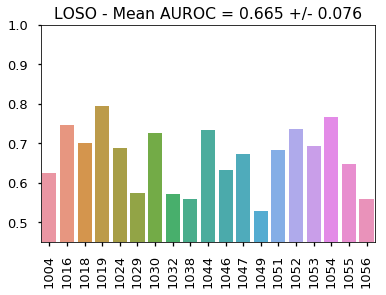

In [35]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [36]:
plt.savefig('Results/BradyLOSOMeanAUROC.png',format='png',dpi=1000)
#np.load(os.path.join(results_path,'Results\Plots\Bradykinesia LOSO Mean AUROC.png'))

C:\Users\Public\Documents\Anaconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


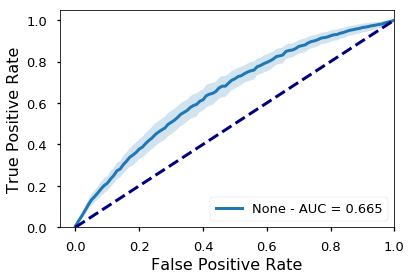

In [37]:
plot_roc(res_group['Random Forest']['tpr'],res_group['Random Forest']['fpr'][0],np.mean(res_group['Random Forest']['auroc']))

In [19]:
plt.savefig('Results/BradyLOSOROC.png',format='png',dpi=1000)

### Tremor

In [17]:
t1=time.time()
res_all = pd.DataFrame()

#Data = Dataorig.copy()
#Data=Data.reset_index(drop=True) #reset index

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 3729/14025 = 0.27
Training Random Forest

Subj/Visit 0, prec=0.237, rec=0.442, Spec=0.860, auroc_train=1.000, auroc=0.713

Subj/Visit 1, prec=0.759, rec=0.179, Spec=0.967, auroc_train=1.000, auroc=0.824

Subj/Visit 2, prec=0.576, rec=0.360, Spec=0.949, auroc_train=1.000, auroc=0.849

Subj/Visit 3, prec=0.159, rec=0.277, Spec=0.901, auroc_train=1.000, auroc=0.730

Subj/Visit 4, prec=0.630, rec=0.374, Spec=0.888, auroc_train=1.000, auroc=0.775

Subj/Visit 5, prec=0.588, rec=0.389, Spec=0.795, auroc_train=1.000, auroc=0.716

Subj/Visit 6, prec=0.714, rec=0.667, Spec=0.974, auroc_train=1.000, auroc=0.978

Subj/Visit 7, prec=0.436, rec=0.708, Spec=0.953, auroc_train=1.000, auroc=0.941

Subj/Visit 8, prec=0.946, rec=0.470, Spec=0.968, auroc_train=1.000, auroc=0.875


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.128, rec=0.038, Spec=0.813, auroc_train=1.000, auroc=0.211

Subj/Visit 11, prec=0.954, rec=0.501, Spec=0.916, auroc_train=1.000, auroc=0.886

Subj/Visit 12, prec=0.008, rec=0.143, Spec=0.882, auroc_train=1.000, auroc=0.853
f1_test=0.367+/-0.233, prec=0.472+/-0.323, rec=0.350+/-0.210, auprc=0.525+/-0.279, auroc=0.779+/-0.190
Elapsed time = 0.665 min


In [21]:
resultstremor = res_group['Random Forest']['auroc']

In [22]:
np.save('./Results/resultstremorLOSO.npy',resultstremor)

Removing nans

Text(0.5,1,'LOSO - Mean AUROC = 0.513 +/- 0.103')

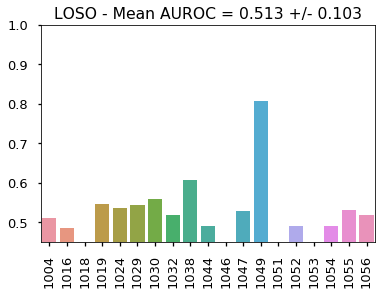

In [23]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [24]:
plt.savefig('Results/TremorLOSOMeanAUROC.png',format='png',dpi=1000)

In [25]:
#plot_roc(res_group['Random Forest']['tpr'],res_group['Random Forest']['fpr'][0],np.mean(res_group['Random Forest']['auroc']))

## Personal Models

In [18]:
def personalModel(symptom):
    le = LabelEncoder()
    res_all = pd.DataFrame(data=None,index=None)
    #train on all sessions, predict on left out session for each patient
    res_visit_all = [] #data from each subject 

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index

    for s in Data.Subject.unique():
        print('Subject %s'%s)
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,5:]
        X_std = StandardScaler().fit_transform(X) #standardize input data
        models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
        model_name = ['Random Forest']#,'XGB']
        models = list(zip(models,model_name))
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        res,res_group = LOSOCV(ds,X_std,y,groups,models)
        res.index = res.index+s
        res_all=pd.concat((res_all,res))
        res_visit_all.append(res_group)
        
    return res_all, res_visit_all

In [19]:
symptom = 'Bradykinesia'
brady_res_all,brady_res_visit_all = personalModel(symptom)

Subject 1004
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.138, Spec=1.000, auroc_train=1.000, auroc=0.743

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.879, auroc_train=1.000, auroc=0.478

Subj/Visit 2, prec=0.510, rec=1.000, Spec=0.733, auroc_train=1.000, auroc=0.990


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.000, auroc=nan

Subj/Visit 4, prec=0.154, rec=0.143, Spec=0.907, auroc_train=1.000, auroc=0.842

Subj/Visit 5, prec=0.976, rec=0.588, Spec=0.976, auroc_train=1.000, auroc=0.874
f1_test=0.300+/-0.299, prec=0.440+/-0.423, rec=0.311+/-0.366, auprc=0.631+/-0.377, auroc=0.785+/-0.173
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.967, rec=0.922, Spec=0.733, auroc_train=1.000, auroc=0.898

Subj/Visit 1, prec=0.916, rec=1.000, Spec=0.630, auroc_train=1.000, auroc=0.986

Subj/Visit 2, prec=0.913, rec=1.000, Spec=0.542, auroc_train=1.000, auroc=0.996

Subj/Visit 3, prec=1.000, rec=0.977, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.840, rec=0.991, Spec=0.444, auroc_train=1.000, auroc=0.750

Subj/Visit 5, prec=0.944, rec=0.929, Spec=0.682, auroc_train=1.000, auroc=0.960

Subj/Visit 6, prec=1.000, rec=0.964, Spec=1.000, auroc_train=1.000, auroc=0.996


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.613, rec=0.667, Spec=0.540, auroc_train=1.000, auroc=0.713
f1_test=0.565+/-0.236, prec=0.594+/-0.285, rec=0.589+/-0.279, auprc=0.904+/-0.074, auroc=0.791+/-0.112
Subject 1024
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.771, Spec=1.000, auroc_train=1.000, auroc=0.960

Subj/Visit 1, prec=0.738, rec=0.923, Spec=0.754, auroc_train=1.000, auroc=0.919

Subj/Visit 2, prec=0.636, rec=1.000, Spec=0.594, auroc_train=1.000, auroc=0.888

Subj/Visit 3, prec=0.844, rec=0.743, Spec=0.483, auroc_train=1.000, auroc=0.593

Subj/Visit 4, prec=0.833, rec=0.597, Spec=0.849, auroc_train=1.000, auroc=0.881

Subj/Visit 5, prec=0.495, rec=0.923, Spec=0.380, auroc_train=1.000, auroc=0.765
f1_test=0.767+/-0.076, prec=0.758+/-0.161, rec=0.826+/-0.136, auprc=0.849+/-0.095, auroc=0.835+/-0.123
Subject 1029
Training Random Forest

Subj/Visit 0, prec=0.685, rec=0.673, Spec=0.333, auroc_train=1.000, auroc=0.567

Subj/Visit 1, prec=0.829, rec=0.969, Spec=0.812, auroc_train=1.000, auroc

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.824
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.969, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.993, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.697
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.269+/-0.110, auroc=0.697+/-0.104
Subject 1044
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less


Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.685
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.984, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.693
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.310+/-0.031, auroc=0.689+/-0.004
Subject 1046
Training Random Forest

Subj/Visit 0, prec=0.959, rec=0.723, Spec=0.963, auroc_train=1.000, auroc=0.952

Subj/Visit 1, prec=0.742, rec=0.958, Spec=0.750, auroc_train=1.000, auroc=0.953

Subj/Visit 2, prec=0.697, rec=1.000, Spec=0.677, auroc_train=1.000, auroc=0.982

Subj/Visit 3, prec=0.812, rec=0.812, Spec=0.765, auroc_train=1.000, auroc=0.912

Subj/Visit 4, prec=0.937, rec=0.819, Spec=0.892, auroc_train=1.000, auroc=0.933

Subj/Visit 5, prec=0.692, rec=0.621, Spec=0.673, auroc_train=1.000, auroc=0.744

Subj/Visit 6, prec=0.833, rec=0.692, Spec=0.809, auroc_train=1.000, auroc=0.787
f1_test=0.797+/-0.067, prec=0.810+/-0.100, rec=0.804+/-0.128, auprc=0.918+/-0.064, auroc=0.895+/-0.085
Subject 1049
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=1

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 2, prec=0.920, rec=1.000, Spec=0.267, auroc_train=1.000, auroc=0.869

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=0.992, rec=0.992, Spec=0.917, auroc_train=1.000, auroc=0.995

Subj/Visit 5, prec=0.906, rec=1.000, Spec=0.071, auroc_train=1.000, auroc=1.000
f1_test=0.976+/-0.019, prec=0.970+/-0.040, rec=0.985+/-0.024, auprc=0.997+/-0.007, auroc=0.966+/-0.056
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.135, Spec=1.000, auroc_train=1.000, auroc=0.857

Subj/Visit 1, prec=0.407, rec=0.524, Spec=0.828, auroc_train=1.000, auroc=0.807

Subj/Visit 2, prec=0.381, rec=1.000, Spec=0.854, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.852, rec=0.359, Spec=0.920, auroc_train=1.000, auroc=0.742

Subj/Visit 4, prec=0.206, rec=1.000, Spec=0.738, auroc_train=1.000, auroc=1.000

Subj/Visit 5, prec=0.714, rec=0.625, Spec=0.939, auroc_train=1.000, auroc=0.905

Subj/Visit 6, prec=0.842, rec=0.286, Spec=0.952, a

In [28]:
resultsbrady_pers=brady_res_all.auroc.values
np.save('Results/resultsbradyPERS.npy',resultsbrady_pers)

In [29]:
Data.shape

(22559, 19)

In [30]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(brady_res_visit_all)):
    if len(brady_res_visit_all[i]['Random Forest']['auroc']) < 7:
        brady_res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = brady_res_visit_all[i]['Random Forest']['auroc']   
    brady_auc = brady_res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(brady_auc)) #mean across visits
    auc_std.append(np.nanstd(brady_auc))

(0.45, 1)

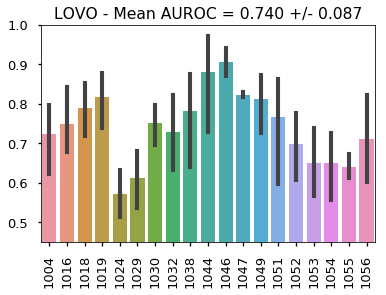

In [31]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(brady_res_all.auroc),np.nanstd(brady_res_all.auroc)))
plt.ylim([0.45,1])

Is variability due to variability in symptoms between visits?

### Tremor

In [32]:
plt.savefig('Results/BradyPERSMeanAUROC.png',format='png',dpi=1000)

In [33]:
symptom = 'Tremor'
tremor_res_all,tremor_res_visit_all = personalModel(symptom)

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.468


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.976, auroc_train=1.000, auroc=0.434
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.977, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.993, auroc_train=1.000, auroc=0.542
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.245+/-0.222, auroc=0.481+/-0.045
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.632, rec=0.732, Spec=0.635, auroc_train=1.000, auroc=0.714

Subj/Visit 1, prec=0.806, rec=0.714, Spec=0.760, auroc_train=1.000, auroc=0.813

Subj/Visit 2, prec=0.792, rec=0.548, Spec=0.808, auroc_train=1.000, auroc=0.780

Subj/Visit 3, prec=0.809, rec=0.768, Spec=0.800, auroc_train=1.000, auroc=0.844

Subj/Visit 4, prec=0.824, rec=0.781, Spec=0.792, auroc_train=1.000, auroc=0.834

Subj/Visit 5, prec=0.840, rec=0.748, Spec=0.770, auroc_train=1.000, auroc=0.834
only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.397, auroc_train=1.000, auroc=nan
f1_test=0.638+/-0.266, prec=0.

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.993, auroc_train=1.000, auroc=0.826

Subj/Visit 1, prec=1.000, rec=0.583, Spec=1.000, auroc_train=1.000, auroc=0.934

Subj/Visit 2, prec=0.500, rec=0.333, Spec=0.967, auroc_train=1.000, auroc=0.859

Subj/Visit 3, prec=1.000, rec=0.067, Spec=1.000, auroc_train=1.000, auroc=0.766

Subj/Visit 4, prec=0.714, rec=0.161, Spec=0.987, auroc_train=1.000, auroc=0.852

Subj/Visit 5, prec=0.500, rec=0.267, Spec=0.976, auroc_train=1.000, auroc=0.884

Subj/Visit 6, prec=0.125, rec=0.059, Spec=0.956, auroc_train=1.000, auroc=0.728
f1_test=0.279+/-0.230, prec=0.548+/-0.363, rec=0.210+/-0.188, auprc=0.488+/-0.159, auroc=0.836+/-0.064
Subject 1019
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.490


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.808

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.880

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.631

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.901


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.813

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.440
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.206+/-0.131, auroc=0.709+/-0.174
Subject 1024
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.679, rec=0.127, Spec=0.900, auroc_train=1.000, auroc=0.534

Subj/Visit 1, prec=0.167, rec=0.182, Spec=0.865, auroc_train=1.000, auroc=0.498

Subj/Visit 2, prec=0.088, rec=0.375, Spec=0.804, auroc_train=1.000, auroc=0.600

Subj/Visit 3, prec=0.667, rec=0.094, Spec=0.935, auroc_train=1.000, auroc=0.583

Subj/Visit 4, prec=0.240, rec=0.261, Spec=0.863, auroc_train=1.000, auroc=0.501

Subj/Visit 5, prec=0.143, rec=0.429, Spec=0.888, auroc_train=1.000, auroc=0.679

Subj/Visit 6, prec=0.385, rec=0.312, Spec=0.891, auroc_train=1.000, auroc=0.662
f1_test=0.215+/-0.063, prec=0.338+/-0.229, rec=0.254+/-0.117, auprc=0.306+/-0.230, auroc=0.579+/-0.068
Subject 1029
Training Random Forest

Subj/Visit 0, prec=0.946, rec=0.338, Spec=0.925, auroc_train=1.000, auroc=0.767

Subj/Visit 1, prec=0.210, rec=0.630, Spec=0.576, auroc_train=1.000, auroc=0.692

Subj/Visit 2, prec=0.145, rec=0.400, Spec=0.590, auroc_train=1.000, auroc=0.475

Subj/Visit 3, prec=0.763, rec=0.409, Spec=0.818, a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.577

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.942, auroc_train=1.000, auroc=0.605


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.627

Subj/Visit 6, prec=1.000, rec=0.056, Spec=1.000, auroc_train=1.000, auroc=0.624
f1_test=0.022+/-0.038, prec=0.151+/-0.347, rec=0.014+/-0.022, auprc=0.175+/-0.043, auroc=0.612+/-0.025
Subject 1032
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.985, auroc_train=1.000, auroc=0.414


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.592

Subj/Visit 2, prec=1.000, rec=0.062, Spec=1.000, auroc_train=1.000, auroc=0.682


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.694


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.898


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.628

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.987, auroc_train=1.000, auroc=0.655
f1_test=0.017+/-0.041, prec=0.143+/-0.350, rec=0.009+/-0.022, auprc=0.157+/-0.108, auroc=0.652+/-0.133
Subject 1038
Training Random Forest

Subj/Visit 0, prec=0.769, rec=0.580, Spec=0.554, auroc_train=1.000, auroc=0.622

Subj/Visit 1, prec=0.510, rec=0.792, Spec=0.330, auroc_train=1.000, auroc=0.629

Subj/Visit 2, prec=0.584, rec=0.753, Spec=0.441, auroc_train=1.000, auroc=0.650

Subj/Visit 3, prec=0.694, rec=0.664, Spec=0.529, auroc_train=1.000, auroc=0.615

Subj/Visit 4, prec=0.737, rec=0.860, Spec=0.551, auroc_train=1.000, auroc=0.779

Subj/Visit 5, prec=0.647, rec=0.750, Spec=0.395, auroc_train=1.000, auroc=0.606

Subj/Visit 6, prec=0.735, rec=0.667, Spec=0.639, auroc_train=1.000, auroc=0.712
f1_test=0.687+/-0.050, prec=0.668+/-0.087, rec=0.724+/-0.086, auprc=0.714+/-0.068, auroc=0.659+/-0.059
Subject 1044
Training Random 

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.667, rec=0.783, Spec=0.939, auroc_train=1.000, auroc=0.955

Subj/Visit 1, prec=0.762, rec=0.552, Spec=0.963, auroc_train=1.000, auroc=0.933

Subj/Visit 2, prec=0.267, rec=0.200, Spec=0.914, auroc_train=1.000, auroc=0.828

Subj/Visit 3, prec=0.882, rec=0.536, Spec=0.985, auroc_train=1.000, auroc=0.976

Subj/Visit 4, prec=0.750, rec=0.656, Spec=0.947, auroc_train=1.000, auroc=0.936

Subj/Visit 5, prec=0.917, rec=0.314, Spec=0.992, auroc_train=1.000, auroc=0.917

Subj/Visit 6, prec=0.143, rec=0.122, Spec=0.741, auroc_train=1.000, auroc=0.593
f1_test=0.508+/-0.222, prec=0.627+/-0.280, rec=0.452+/-0.227, auprc=0.636+/-0.223, auroc=0.877+/-0.124
Subject 1047
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.850
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.941
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.310+/-0.109, auroc=0.895+/-0.045
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.989, rec=0.709, Spec=0.988, auroc_train=1.000, auroc=0.940

Subj/Visit 1, prec=0.793, rec=0.890, Spec=0.798, auroc_train=1.000, auroc=0.861

Subj/Visit 2, prec=0.826, rec=0.905, Spec=0.858, auroc_train=1.000, auroc=0.939

Subj/Visit 3, prec=0.650, rec=0.942, Spec=0.731, auroc_train=1.000, auroc=0.884

Subj/Visit 4, prec=0.571, rec=0.938, Spec=0.664, auroc_train=1.000, auroc=0.863

Subj/Visit 5, prec=0.780, rec=0.736, Spec=0.816, auroc_train=1.000, auroc=0.854

Subj/Visit 6, prec=0.896, rec=0.869, Spec=0.903, auroc_train=1.000, auroc=0.941
f1_test=0.807+/-0.058, prec=0.787+/-0.131, rec=0.855+/-0.088, auprc=0.833+/-0.103, auroc=0.897+/-0.038
Subject 1051
Training Random Forest
only 1 class in test da

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.657


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.839
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.989, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.368+/-0.141, auroc=0.748+/-0.091
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:99: Runti


Subj/Visit 0, prec=0.960, rec=0.986, Spec=0.000, auroc_train=1.000, auroc=0.792

Subj/Visit 1, prec=0.609, rec=0.961, Spec=0.016, auroc_train=1.000, auroc=0.438

Subj/Visit 2, prec=0.678, rec=0.935, Spec=0.127, auroc_train=1.000, auroc=0.563

Subj/Visit 3, prec=0.938, rec=0.958, Spec=0.357, auroc_train=1.000, auroc=0.774

Subj/Visit 4, prec=0.846, rec=0.992, Spec=0.172, auroc_train=1.000, auroc=0.586

Subj/Visit 5, prec=0.993, rec=0.928, Spec=0.000, auroc_train=1.000, auroc=0.497
f1_test=0.887+/-0.089, prec=0.837+/-0.146, rec=0.960+/-0.024, auprc=0.848+/-0.154, auroc=0.608+/-0.132
Subject 1056
Training Random Forest

Subj/Visit 0, prec=0.934, rec=0.929, Spec=0.143, auroc_train=1.000, auroc=0.717

Subj/Visit 1, prec=0.406, rec=0.947, Spec=0.028, auroc_train=1.000, auroc=0.519

Subj/Visit 2, prec=0.388, rec=0.963, Spec=0.146, auroc_train=1.000, auroc=0.692

Subj/Visit 3, prec=0.966, rec=0.914, Spec=0.143, auroc_train=1.000, auroc=0.550
only 1 class in test data - cannot compute roc curv

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


In [34]:
resultstremor_pers=tremor_res_all.auroc.values
np.save('./Results/resultstremorPERS.npy',resultstremor_pers)

In [35]:
Data.shape

(22559, 19)

In [36]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(tremor_res_visit_all)):

    if len(tremor_res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(tremor_res_visit_all[i]['Random Forest']['auroc'])
        tremor_res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = tremor_res_visit_all[i]['Random Forest']['auroc']   
    tremor_auc = tremor_res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(0.45, 1.0)

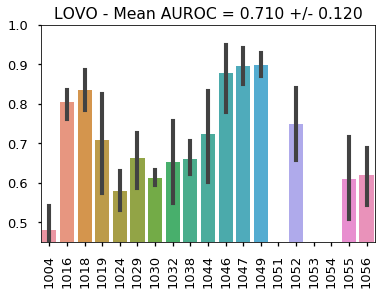

In [37]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(tremor_res_all.auroc),np.nanstd(tremor_res_all.auroc)))
plt.ylim([0.45,1.])

In [38]:
plt.savefig('Results/TremorPERSMeanAUROC.png',format='png',dpi=1000)

## Box plots comparing global and personal

In [39]:
resultstremor = np.load(os.path.join(results_path,'resultstremorLOSO.npy'))
resultsbrady = np.load(os.path.join(results_path,'resultsbradyLOSO.npy'))

In [40]:
resultsbrady_pers=np.load(os.path.join(results_path,'resultsbradyPERS.npy'))
resultstremor_pers=np.load(os.path.join(results_path,'resultstremorPERS.npy'))

In [42]:
results = pd.DataFrame({'Population-Bradykinesia':resultsbrady, 'Personal-Bradykinesia':resultsbrady_pers,
             'Population-Tremor':resultstremor, 'Personal-Tremor':resultstremor_pers})

In [43]:
brady_data = results[['Population-Bradykinesia','Personal-Bradykinesia']]

In [44]:
stats.ttest_rel(results['Personal-Bradykinesia'].values,results['Population-Bradykinesia'].values)

Ttest_relResult(statistic=7.896044143716258, pvalue=2.9510313435967367e-07)

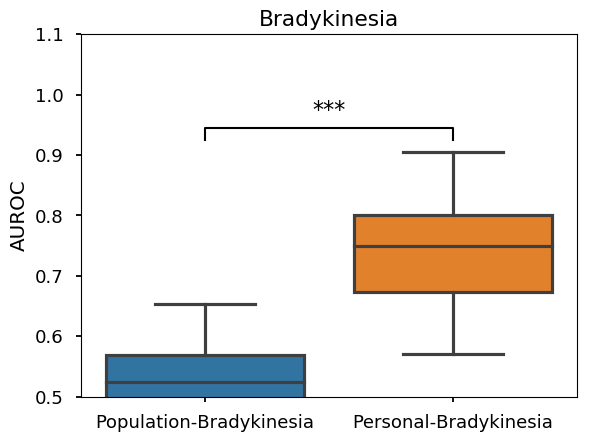

In [45]:
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=brady_data);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Bradykinesia');

x1,x2 = 0,1
y, h, col = brady_data['Personal-Bradykinesia'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Bradykinesia Comparison Boxplot.png',format='png',dpi=1000)
plt.savefig('Results/Bradykinesia Comparison Boxplot.tiff',format='tiff', dpi=1000)

In [46]:
tremor_data = results[['Population-Tremor','Personal-Tremor']]

In [47]:
stats.ttest_rel(results['Personal-Tremor'][~results['Personal-Tremor'].isnull()].values,
                results['Population-Tremor'][~results['Personal-Tremor'].isnull()].values)

Ttest_relResult(statistic=4.840003484992475, pvalue=0.00021625915105267227)

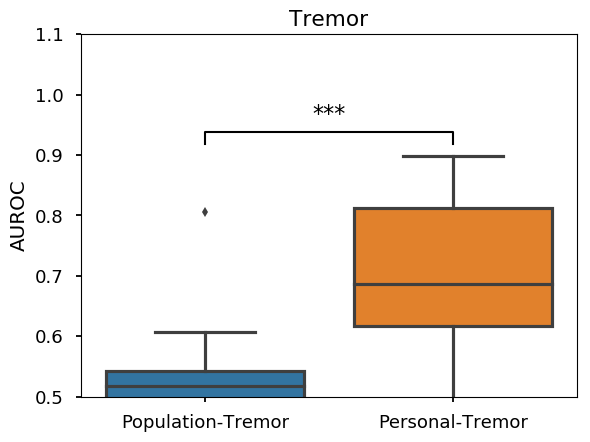

In [48]:
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=tremor_data);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor')

x1,x2 = 0,1
y, h, col = tremor_data['Personal-Tremor'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Results/Tremor Comparison Boxplot.png',format='png',dpi=1000)
plt.savefig('Results/Tremor Comparison Boxplot.tiff',format='tiff',dpi=1000)

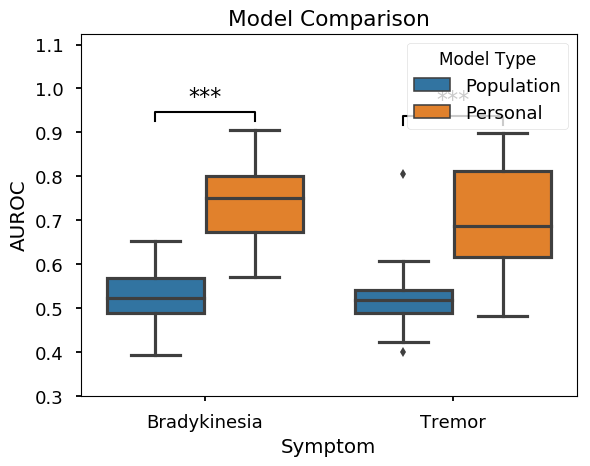

In [49]:
pop1 = brady_data['Population-Bradykinesia']; pop2 = tremor_data['Population-Tremor'];
per1 = brady_data['Personal-Bradykinesia']; per2 = tremor_data['Personal-Tremor'];

g1 = np.shape(pop1)[0]*['Bradykinesia']
g2 = np.shape(pop2)[0]*['Tremor']
df = pd.DataFrame.from_dict({'Symptom':(g1 + g2),'Population':(list(pop1) + list(pop2)),'Personal':(list(per1) + list(per2))})
df_new = pd.melt(df,id_vars=['Symptom'],value_vars=['Population','Personal'],var_name=['Model Type']);

figure = plt.figure();
figure.set_dpi(100);
figure.set_size_inches(6.4,4.8);
ax = sns.boxplot(x='Symptom',y='value',data=df_new,hue='Model Type');

x1,x2 = -0.2,0.2
y, h, col = brady_data['Personal-Bradykinesia'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = tremor_data['Personal-Tremor'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.ylim(0.3,1.125)
plt.ylabel('AUROC');
plt.title('Model Comparison')
plt.savefig('Results/Model Comparison.png',format='png',dpi=1000)
plt.savefig('Results/Model Comparison.tiff',format='tiff',dpi=1000)

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

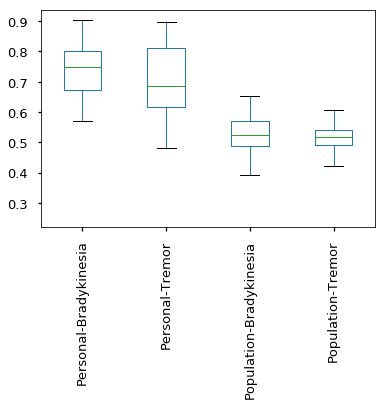

In [50]:
results.plot(kind='box')
plt.xticks(rotation=90)

## Evaluate performance of global models on Subtasks (this section has to be rewritten to train global and personal models on all tasks and analyze performance on each subset of tasks)

In [57]:
from scipy import stats
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [13]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB+taskB1,taskC,taskD]
tasks = tasks# + [list(np.concatenate(tasks))]

Rows w Tremor 8879/38405 = 0.23


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
Clinical 0.7254522705795429 (0.645481352377457, 0.8054231887816288)
Walking 0.6817116654214878 (0.45570259358973775, 0.9077207372532378)


C:\Users\andre\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Gross Motor 0.5688706557060916 (0.5083018179980237, 0.6294394934141596)
Fine Motor 0.702510620199436 (0.6031355974062202, 0.8018856429926517)
Elapsed time = 15.996 min


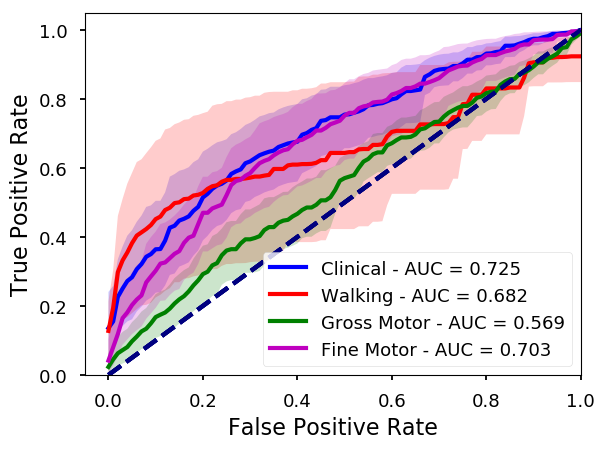

In [14]:
# Global Models
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index
ind=1

# for symptom in ['Bradykinesia']:
for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV_Tasks(Data,X,y,groups,tasks,models[0][0])
    res_all = pd.concat((res_all,res))
    
    Tasks = list(res_group.keys())
    AX=None
#     plt.figure(figsize=(9,6))

    figure = plt.figure()
    figure.set_dpi(100)
    figure.set_size_inches(6.4,4.8)
    
    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor', 'All']
    for x,T in zip(range(len(Tasks)),Tasks):
        NanInds = []
        for i in range(len(res_group[T]['auroc'])):
            if np.isnan(res_group[T]['auroc'][i]):
                NanInds.append(i)
        for i in sorted(NanInds,reverse=True):
            del res_group[T]['tpr'][i]
            del res_group[T]['auroc'][i]
            
        AUC = res_group[T]['auroc']
        print(TaskNames[x],np.mean(AUC),
              stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
            
        if AX==None:
            AX = plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],ax=AX,col=cols[x])
    
    save_object(res_group,symptom+'DataResults')
    plt.savefig(symptom+'Tasks.tiff',format='tiff',dpi=1000)
    plt.savefig(symptom+'Tasks.png',format='png',dpi=1000)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

In [ ]:
file.close()

In [35]:
with open('BradykinesiaDataResults','rb') as file:
    BradykinesiaRes = pickle.load(file)
    
# with open('TremorDataResults','rb') as file:
#     TremorRes = pickle.load(file)

In [36]:
for k in BradykinesiaRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(BradykinesiaRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              BradykinesiaRes[k]['auroc']))
    except:
        continue

('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
Ttest_indResult(statistic=0.0, pvalue=1.0)
('Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #1: Standing', 'Motor #13: Sitting')
Ttest_indResult(statistic=-0.6186182201885729, pvalue=0.5405467883012931)
('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
Ttest_indResult(statistic=1.61336345178503, pvalue=0.11713683600421766)
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Ttest_indResult(statistic=-0.9733509825919716, pvalue=0.3374600719691072)


In [ ]:
for k in TremorRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(TremorRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              TremorRes[k]['auroc']))
    except:
        continue

In [ ]:
save_object(res_group,symptom+'DataResults')
plt.savefig(symptom+'Tasks.svg')
plt.savefig(symptom+'Tasks.png')

Rows w Bradykinesia 16574/32368 = 0.51
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if 

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall 

only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being s

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\l

only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMe

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being s

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:44

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


Clinical 0.8735247548054149 (0.7981789902272396, 0.9488705193835902)
Walking 0.7779524743115989 (0.6644896801300136, 0.8914152684931841)


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Gross Motor 0.6961858206334187 (0.6137415473364669, 0.7786300939303705)
Fine Motor 0.8667754771775347 (0.8222353470649296, 0.9113156072901397)
Elapsed time = 2.439 min


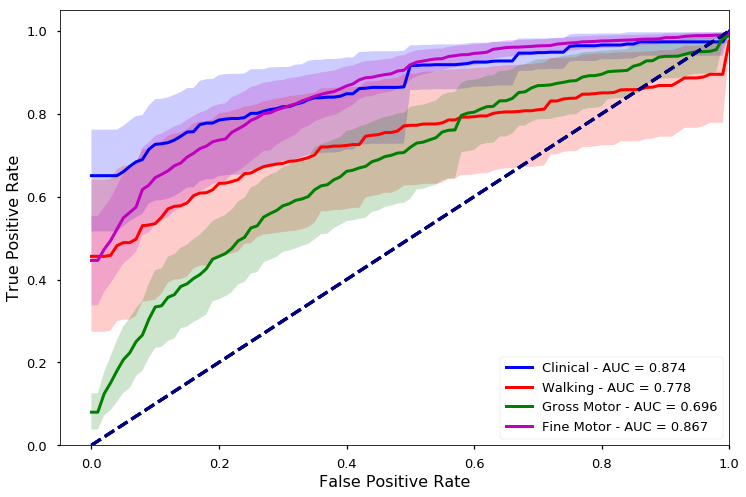

In [33]:
# Personal Models
t1=time.time()
res_all = pd.DataFrame()
le = LabelEncoder()
Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:#, 'Tremor']:
    
    res_allvisits = {}
    for T in tasks:
        res_allvisits[tuple(T)] = {'tpr':[],'fpr':[],'auroc':[]}
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    for s in Data.Subject.unique():
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,7:]
        X_std = StandardScaler().fit_transform(X) #standardize input data
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        

        models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
        model_name = ['Random Forest']
        models = list(zip(models,model_name))

        res,res_group = LOSOCV_Tasks(ds,X_std,y,groups,tasks,models[0][0])
        
        #loop through visits and remove NaNs
        for T in res_group.keys():
            NanInds = []
            for i in range(len(res_group[T]['auroc'])):
                if np.isnan(res_group[T]['auroc'][i]):
                    NanInds.append(i)
            for i in sorted(NanInds,reverse=True):
                del res_group[T]['tpr'][i]
                del res_group[T]['auroc'][i]
            if len(res_group[T]['auroc'])>0:
                res_allvisits[T]['tpr'].append(np.nanmean(res_group[T]['tpr'],axis=0))
                res_allvisits[T]['fpr'].append(np.nanmean(res_group[T]['fpr'],axis=0))
                res_allvisits[T]['auroc'].append(np.nanmean(res_group[T]['auroc']))
        
    Tasks = list(res_group.keys())
    AX=None
#     plt.figure(figsize=(9,6))

    figure = plt.figure()
    figure.set_dpi(100)
    figure.set_size_inches(6.4,4.8)
    
    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor', 'All']
    for x,T in zip(range(len(Tasks)),Tasks):
        
        AUC = res_allvisits[T]['auroc']
        print(TaskNames[x],np.mean(AUC),
              stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
        
        if AX==None:
            AX = plot_roc(res_allvisits[T]['tpr'],res_allvisits[T]['fpr'][0],np.mean(res_allvisits[T]['auroc']),
                          plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_allvisits[T]['tpr'],res_allvisits[T]['fpr'][0],np.mean(res_allvisits[T]['auroc']),
                     plotname=TaskNames[x],ax=AX,col=cols[x])

    save_object(res_allvisits,symptom+'PersonalDataResults')
    plt.savefig(symptom+'Tasks.jpg')
    plt.savefig(symptom+'Tasks.png',format='png',dpi=1000)
    

print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

In [37]:
with open('BradykinesiaPersonalDataResults','rb') as file:
    BradykinesiaRes = pickle.load(file)
    
# with open('TremorPersonalDataResults','rb') as file:
#     TremorRes = pickle.load(file)

In [38]:
for k in BradykinesiaRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(BradykinesiaRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              BradykinesiaRes[k]['auroc']))
    except:
        continue

('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
Ttest_indResult(statistic=0.0, pvalue=1.0)
('Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #1: Standing', 'Motor #13: Sitting')
Ttest_indResult(statistic=1.445519740597778, pvalue=0.15803501687521393)
('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
Ttest_indResult(statistic=3.4016815506537594, pvalue=0.001971846311262386)
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Ttest_indResult(statistic=0.16965776718290307, pvalue=0.8663150777864876)


In [ ]:
for k in TremorRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(TremorRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              TremorRes[k]['auroc']))
    except:
        continue

# Effect of # of subjects

In [ ]:
# #if want to use only the selected features (to speed up)
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

### Bradykinesia

In [ ]:
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

In [ ]:
symptom

In [ ]:
#sample p subjects at random for train and test on 1 random remaining subject

results = pd.DataFrame()
subjs=Data.Subject.unique()
nsubj = [4,6,8,12,16] #of subjects to train on
clf = RandomForestClassifier(n_estimators=50,random_state=2)
auc_all={}
testsublist = []
t1=time.time()

for iteration in range(500):
    

    trainsubjall = np.random.choice(subjs,size=16,replace=False) #sample 16 subjects at random
    
    #pick a test subject at random
    losubjs = Data[~Data.Subject.isin(trainsubjall)].Subject.unique()
    testsubj = np.random.choice(losubjs)
    dtest = Data[Data.Subject==testsubj]
    testsublist.append(testsubj)
    
    #use top features
    Xte = dtest.iloc[:,7:].as_matrix()
#     Xte = dtest[topf].as_matrix()
    yte = (dtest[symptom]>0).values.astype(int)

    if iteration%10==0:
        print(iteration,trainsubjall,testsubj)

    #compute and store AUC for an incremental number of train subjects tested on the left out subject
    for NS in nsubj:
    
        trainsubj = trainsubjall[:NS] #add subjects incrementally each time
        dtrain = Data[Data.Subject.isin(trainsubj)]

        Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
#         Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)

        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auc_all.update({NS:auroc}) #store auc for each grp


    results=pd.concat((results,pd.DataFrame(auc_all,index=[iteration])))
    


#     results.update({ng:auc_all}) #save auc for all runs for each group
print('elapsed %.3f min'%((time.time()-t1)/60))


In [ ]:
results.to_csv('SimsMultiSubj_Brady.csv')

In [ ]:
np.save('SimsMultiSubj_testsublist_brady.npy',testsublist)

Bradykinesia Results

In [ ]:
results=pd.read_csv('SimsMultiSubj_Brady.csv',index_col=False)
results=results.drop('Unnamed: 0',axis=1)

In [ ]:
results2=results.iloc[:,1:].copy()

In [ ]:
baseline = results.iloc[:,0].copy()

In [ ]:
diffs = results2.apply(lambda x:x - baseline)

In [ ]:
diffs.plot(kind='box')

In [ ]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [ ]:
diffs['TestSubj']= testsublist

In [ ]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='6',data=diffs)

In [ ]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='16',data=diffs)

In [ ]:
a.shape

### Tremor Results

In [ ]:
results=pd.read_csv('SimsMultiSubj_Tremor.csv',index_col=False)

In [ ]:
results=results.drop('Unnamed: 0',axis=1)

In [ ]:
results=results.dropna()

In [ ]:
results2=results.iloc[:,1:].copy()

In [ ]:
baseline = results.iloc[:,0].copy()

In [ ]:
diffs = results2.apply(lambda x:x - baseline)

In [ ]:
diffs.plot(kind='box')

In [ ]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [ ]:
Xtr.shape

In [ ]:
# y=np.asarray(diffs)
# x = diffs.columns.values
# sns.tsplot(y,x,ci='sd')

## Personal models - Leave One visit out and LOin on Day 1 and Day 2

In [12]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,rangeXacc,rangeYacc,rangeZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.750286,0.950312,0.792986,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.593042,0.814818,0.511329,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


Train on 1 session

In [13]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 
    
    if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
        print('only 1 class available in data - skipping')
        continue
        
    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2
        
day1_1 = day1_1[~np.isnan(day1_1)]
auroc2_1 = [x for x in auroc2_1 if str(x) != 'nan']

# np.save(os.path.join(results_path,'PERS_brady_train1lovo.npy'),[day1_1.values, auroc2_1])
np.save(os.path.join(results_path,'PERS_tremor_train1lovo.npy'),[day1_1.values, auroc2_1])

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.013, rec=1.000, Spec=0.269, auroc_train=1.000, auroc=0.818
only 1 class available in train data - skipping
only 1 class available in train data - skipping

Subj/Visit 1, prec=1.000, rec=0.032, Spec=1.000, auroc_train=1.000, auroc=0.512
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=0.044+/-0.018, prec=0.507+/-0.493, rec=0.516+/-0.484, auprc=0.155+/-0.094, auroc=0.665+/-0.153
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.775, rec=0.853, Spec=0.706, auroc_train=1.000, auroc=0.869

Subj/Visit 1, prec=0.850, rec=0.907, Spec=0.820, auroc_train=1.000, auroc=0.927

Subj/Visit 2, prec=0.828, rec=0.875, Spec=0.794, auroc_train=1.000, auroc=0.896

Subj/Visit 3, prec=0.838, rec=0.874, Spec=0.805, auroc_train=1.000, auroc=0.909

Subj/Visit 4, prec=0.832, rec=0.875, Spec=0.802, auroc_train=1.000, auroc=0.907

Subj/Visit 5, prec=0.851, rec=0.873, Spec=0.83

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.510
f1_test=0.146+/-0.154, prec=0.433+/-0.325, rec=0.301+/-0.398, auprc=0.372+/-0.058, auroc=0.594+/-0.065
Test 1024 on day 2
Subject 1029
Training Random Forest

Subj/Visit 0, prec=0.339, rec=0.965, Spec=0.268, auroc_train=1.000, auroc=0.714

Subj/Visit 1, prec=0.867, rec=0.019, Spec=0.998, auroc_train=1.000, auroc=0.710

Subj/Visit 2, prec=0.850, rec=0.026, Spec=0.997, auroc_train=1.000, auroc=0.628

Subj/Visit 3, prec=0.471, rec=0.845, Spec=0.538, auroc_train=1.000, auroc=0.738

Subj/Visit 4, prec=0.589, rec=0.535, Spec=0.783, auroc_train=1.000, auroc=0.716

Subj/Visit 5, prec=0.664, rec=0.271, Spec=0.913, auroc_train=1.000, auroc=0.733
f1_test=0.357+/-0.231, prec=0.630+/-0.190, rec=0.444+/-0.371, auprc=0.557+/-0.043, auroc=0.706+/-0.036
Test 1029 on day 2
Subject 1030
Training Random Forest

Subj/Visit 0, prec=0.960, rec=0.250, Spec=0.999, auroc_train=1.000, auroc=0.913

Subj/Visit 1, prec=0.875, rec=0.700

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.056, rec=0.667, Spec=0.761, auroc_train=1.000, auroc=0.772
only 1 class available in train data - skipping
only 1 class available in train data - skipping

Subj/Visit 1, prec=1.000, rec=0.032, Spec=1.000, auroc_train=1.000, auroc=0.658
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=0.082+/-0.021, prec=0.528+/-0.472, rec=0.349+/-0.317, auprc=0.157+/-0.001, auroc=0.715+/-0.057
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
only 1 class available in data - skipping
Subject 1054
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ran


Subj/Visit 0, prec=0.787, rec=0.995, Spec=0.007, auroc_train=1.000, auroc=0.574

Subj/Visit 1, prec=0.853, rec=0.649, Spec=0.333, auroc_train=1.000, auroc=0.559

Subj/Visit 2, prec=0.872, rec=0.821, Spec=0.335, auroc_train=1.000, auroc=0.647

Subj/Visit 3, prec=0.821, rec=0.956, Spec=0.185, auroc_train=1.000, auroc=0.600

Subj/Visit 4, prec=0.848, rec=0.824, Spec=0.346, auroc_train=1.000, auroc=0.637

Subj/Visit 5, prec=0.779, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.506
f1_test=0.843+/-0.050, prec=0.827+/-0.034, rec=0.874+/-0.125, auprc=0.885+/-0.012, auroc=0.587+/-0.048
Subject 1056
Training Random Forest

Subj/Visit 0, prec=0.720, rec=0.956, Spec=0.068, auroc_train=1.000, auroc=0.519

Subj/Visit 1, prec=0.889, rec=0.386, Spec=0.781, auroc_train=1.000, auroc=0.620

Subj/Visit 2, prec=0.914, rec=0.161, Spec=0.923, auroc_train=1.000, auroc=0.578

Subj/Visit 3, prec=0.714, rec=0.986, Spec=0.048, auroc_train=1.000, auroc=0.592
only 1 class available in train data - skipping

Su

Train on 5 sessions

In [14]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_5 = res_all.auroc #mean auc per subject across 

    if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
        print('only 1 class available in data - skipping')
        continue
    
    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_5.append(auroc) #auc from each subject when tested on day 2

        
day1_5 = day1_5[~np.isnan(day1_5)]
auroc2_5 = [x for x in auroc2_5 if str(x) != 'nan']

# np.save(os.path.join(results_path,'PERS_brady_train5lovo.npy'),[day1_5.values, auroc2_5])
np.save(os.path.join(results_path,'PERS_tremor_train5lovo.npy'),[day1_5.values, auroc2_5])

Subject 1004
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.563


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.750, rec=0.923, Spec=0.985, auroc_train=1.000, auroc=0.998


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.138+/-0.308, prec=0.125+/-0.280, rec=0.154+/-0.344, auprc=0.813+/-0.160, auroc=0.781+/-0.217
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.827, rec=0.872, Spec=0.832, auroc_train=1.000, auroc=0.893

Subj/Visit 1, prec=0.849, rec=0.919, Spec=0.807, auroc_train=1.000, auroc=0.947

Subj/Visit 2, prec=0.839, rec=0.896, Spec=0.801, auroc_train=1.000, auroc=0.945

Subj/Visit 3, prec=0.908, rec=0.946, Spec=0.900, auroc_train=1.000, auroc=0.968

Subj/Visit 4, prec=0.922, rec=0.939, Spec=0.904, auroc_train=1.000, auroc=0.977

Subj/Visit 5, prec=0.885, rec=0.932, Spec=0.836, auroc_train=1.000, auroc=0.955
f1_test=0.894+/-0.030, prec=0.872+/-0.035, rec=0.917+/-0.026, auprc=0.938+/-0.050, auroc=0.948+/-0.027
Test 1016 on day 2
only 1 class in test data - cannot compute roc curve
Subject 1018
Training Random Forest

Subj/Visit 0

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.994
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.989


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.788+/-0.043, auroc=0.991+/-0.002
Subject 1049
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0, prec=0.886, rec=0.732, Spec=0.864, auroc_train=1.000, auroc=0.878

Subj/Visit 1, prec=0.837, rec=0.769, Spec=0.886, auroc_train=1.000, auroc=0.898

Subj/Visit 2, prec=0.812, rec=0.800, Spec=0.867, auroc_train=1.000, auroc=0.926

Subj/Visit 3, prec=0.846, rec=0.393, Spec=0.965, auroc_train=1.000, auroc=0.864

Subj/Visit 4, prec=0.806, rec=0.806, Spec=0.917, auroc_train=1.000, auroc=0.948

Subj/Visit 5, prec=0.800, rec=0.667, Spec=0.871, auroc_train=1.000, auroc=0.860
f1_test=0.747+/-0.098, prec=0.831+/-0.030, rec=0.694+/-0.143, auprc=0.868+/-0.053, auroc=0.896+/-0.032
Test 1049 on day 2
Subject 1051
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, a

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=1.000, rec=0.011, Spec=1.000, auroc_train=1.000, auroc=0.687


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.500, rec=0.033, Spec=0.996, auroc_train=1.000, auroc=0.751


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.014+/-0.023, prec=0.250+/-0.382, rec=0.007+/-0.012, auprc=0.346+/-0.161, auroc=0.719+/-0.032
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
only 1 class available in data - skipping
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0, prec=0.955, rec=0.955, Spec=0.083, auroc_train=1.000, auroc=0.628

Subj/Visit 1, prec=0.590, rec=0.902, Spec=0.056, auroc_train=1.000, auroc=0.547

Subj/Visit 2, prec=0.683, rec=0.960, Spec=0.160, auroc_train=1.000, auroc=0.661

Subj/Visit 3, prec=0.937, rec=0.937, Spec=0.444, auroc_train=1.000, auroc=0.877

Subj/Visit 4, prec=0.832, rec=0.986, Spec=0.204, auroc_train=1.000, auroc=0.786

Subj/Visit 5, prec=0.991, rec=0.913, Spec=0.000, auroc_train=1.000, auroc=0.500
f1_test=0.876+/-0.090, prec=0.831+/-0.149, rec=0.942+/-0.029, auprc=0.889+/-0.123, auroc=0.666+/-0.131
Subject 1056
Tra

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.889, rec=0.932, Spec=0.077, auroc_train=1.000, auroc=0.616
f1_test=0.799+/-0.199, prec=0.755+/-0.284, rec=0.937+/-0.033, auprc=0.799+/-0.249, auroc=0.710+/-0.103


#### Run Stats and Plot

In [90]:
# brady1 = np.load(os.path.join(results_path,'brady_train1lovo.npy'))
# brady5 = np.load(os.path.join(results_path,'brady_train5lovo.npy'))
# tremor1 = np.load(os.path.join(results_path,'tremor_train1lovo.npy'))
# tremor5 = np.load(os.path.join(results_path,'tremor_train5lovo.npy'))

# day1_1 = np.append(brady1[0], tremor1[0]);
# auroc2_1 = brady1[1] + tremor1[1];
# day1_5 = np.append(brady5[0], tremor5[0]);
# auroc2_5 = brady5[1] + tremor5[1];

# s1 = (np.shape(brady1[0])[0])*['Bradykinesia'] + (np.shape(tremor1[0])[0])*['Tremor']
# s2 = (np.shape(brady1[1])[0])*['Bradykinesia'] + (np.shape(tremor1[1])[0])*['Tremor']
# g1 = np.shape(day1_1)[0]*['Day 1']
# g2 = np.shape(auroc2_1)[0]*['Day 2']
# df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(day1_1) + list(auroc2_1)),
#                              '5 Sessions':(list(day1_5) + list(auroc2_5)),
#                              'Symptom':(list(s1) + list(s2))})
# df_new = pd.melt(df,id_vars=['Test Session','Symptom'],value_vars=['1 Session','5 Sessions'],var_name=['# Training Sessions']);

# figure = plt.figure();
# figure.set_dpi(100);
# figure.set_size_inches(6.4,4.8);
# # ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
# ax = sns.factorplot(x='Test Session',y='value',hue='# Training Sessions',data=df_new,col='Symptom',kind='box');
# # ax = (ax.map(labelFunc),color='k')
# ax.set_titles('{col_name}');

# # x3,x4 = 0.8,1.2
# # y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
# # plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

# # # if pvalue2 > 0.05:
# # plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
# # # else:
# # plt.text((x3+x4)*.5, y+h, "***"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# # plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.png'),format='png',dpi=1000)
# # plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.tiff'),format='tiff',dpi=1000)

In [5]:
# day1_1 = np.load(os.path.join(results_path,'brady_train1lovo.npy'))[0]
# auroc2_1 = np.load(os.path.join(results_path,'brady_train1lovo.npy'))[1]
# day1_5 = np.load(os.path.join(results_path,'brady_train5lovo.npy'))[0]
# auroc2_5 = np.load(os.path.join(results_path,'brady_train5lovo.npy'))[1]

# g1 = np.shape(day1_1)[0]*['Day 1']
# g2 = np.shape(auroc2_1)[0]*['Day 2']
# df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(day1_1) + list(auroc2_1)),'5 Sessions':(list(day1_5) + list(auroc2_5))})
# df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','5 Sessions'],var_name=['# Training Sessions'])

# figure = plt.figure()
# figure.set_dpi(100)
# figure.set_size_inches(6.4,4.8)
# ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
# plt.ylabel('AUROC');
# plt.title('Bradykinesia');
# plt.ylim(0.3,1.15);

# #stats
# # _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
# _, pvalue1 = stats.ttest_rel(day1_1,day1_5)
# print('Bradykinesia Day 1 mean: %f p-value: %f'%((np.mean(day1_5-day1_1)),pvalue1))

# # _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
# _, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_5)
# print('Bradykinesia Day 2 mean: %f p-value: %f'%((np.mean(np.array(auroc2_5)-np.array(auroc2_1))),pvalue2))

# x1,x2 = -0.2,0.2
# y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue1 > 0.05:
#     plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x1+x2)*.5, y+h+0.01, "***"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

# x3,x4 = 0.8,1.2
# y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
# plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue2 > 0.05:
#     plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x3+x4)*.5, y+h, "***"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.png'),format='png',dpi=1000)
# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.tiff'),format='tiff',dpi=1000)

In [6]:
# day1_1 = np.load(os.path.join(results_path,'tremor_train1lovo.npy'))[0]
# auroc2_1 = np.load(os.path.join(results_path,'tremor_train1lovo.npy'))[1]
# day1_5 = np.load(os.path.join(results_path,'tremor_train5lovo.npy'))[0]
# auroc2_5 = np.load(os.path.join(results_path,'tremor_train5lovo.npy'))[1]

# g1 = np.shape(day1_1)[0]*['Day 1']
# g2 = np.shape(auroc2_1)[0]*['Day 2']
# df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(day1_1) + list(auroc2_1)),'5 Sessions':(list(day1_5) + list(auroc2_5))})
# df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','5 Sessions'],var_name=['# Training Sessions'])

# figure = plt.figure()
# figure.set_dpi(100)
# figure.set_size_inches(6.4,4.8)
# ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
# plt.ylabel('AUROC');
# plt.title('Tremor');
# plt.ylim(0.3,1.15);

# #stats
# # _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
# _, pvalue1 = stats.ttest_rel(day1_1,day1_5)
# print('Tremor Day 1 mean: %f p-value: %f'%((np.mean(day1_5-day1_1)),pvalue1))

# # _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
# _, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_5)
# print('Tremor Day 2 mean: %f p-value: %f'%((np.mean(np.array(auroc2_5)-np.array(auroc2_1))),pvalue2))

# x1,x2 = -0.2,0.2
# y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue1 > 0.05:
#     plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x1+x2)*.5, y+h+0.01, "***"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

# x3,x4 = 0.8,1.2
# y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
# plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue2 > 0.05:
#     plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x3+x4)*.5, y+h, "***"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Tremor.png'),format='png',dpi=1000)
# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Tremor.tiff'),format='tiff',dpi=1000)

# Boxplots

## Bradykinesia - Compare Day 1, 1 sessions and all sessions for training, test on remaining

In [5]:
global_one = np.load(os.path.join(results_path,'GLOB_brady_train1lovo.npy'))[0]
global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_brady_train6lovo.npy'))[0]
global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_brady_train1lovo.npy'))[0]
person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_brady_train5lovo.npy'))[0]
person_all = np.asarray(person_all)[~np.isnan(person_all)]

_, pvalue1 = stats.ttest_rel(global_one,global_all)
_, pvalue2 = stats.ttest_rel(person_one,person_all)
print('Bradykinesia Day 1\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Bradykinesia Day 1

Population Model p-value: 0.013612, mean improvement: 0.013900
Personal Model p-value: 0.000000, mean improvement: 0.111878


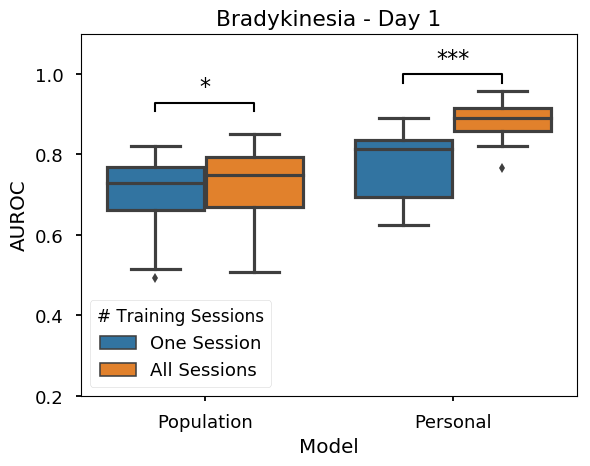

In [6]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Bradykinesia - Day 1');
plt.ylim(0.2,1.1);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() - 0.05, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "*", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Bradykinesia Day 1 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Bradykinesia Day 1 Comparison.png'),format='png',dpi=1000)

## Bradykinesia - Compare Day 2, 1 sessions and all sessions for training, test on remaining

In [7]:
global_one = np.load(os.path.join(results_path,'GLOB_brady_train1lovo.npy'))[1]
global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_brady_train6lovo.npy'))[1]
global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_brady_train1lovo.npy'))[1]
person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_brady_train5lovo.npy'))[1]
person_all = np.asarray(person_all)[~np.isnan(person_all)]

_, pvalue1 = stats.ttest_rel(global_one,global_all)
_, pvalue2 = stats.ttest_rel(person_one,person_all)
print('Bradykinesia Day 2\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Bradykinesia Day 2

Population Model p-value: 0.394027, mean improvement: 0.009822
Personal Model p-value: 0.123859, mean improvement: 0.041002


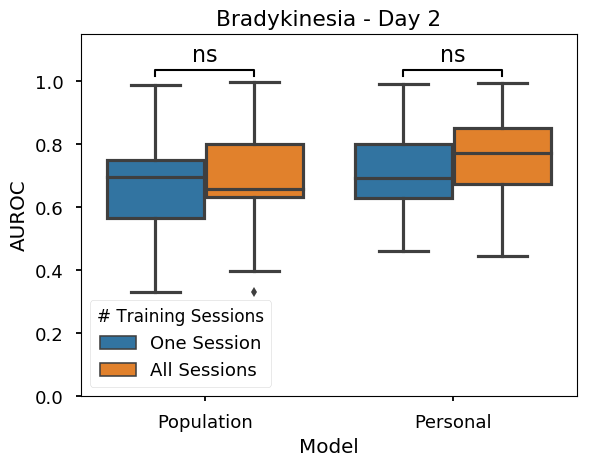

In [8]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Bradykinesia - Day 2');
plt.ylim(0,1.15);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Bradykinesia Day 2 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Bradykinesia Day 2 Comparison.png'),format='png',dpi=1000)

## Tremor - Compare Day 1, 1 sessions and all sessions for training, test on remaining

In [9]:
global_one = np.load(os.path.join(results_path,'GLOB_tremor_train1lovo.npy'))[0]
# global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_tremor_train6lovo.npy'))[0]
# global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_tremor_train1lovo.npy'))[0]
# person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_tremor_train5lovo.npy'))[0]
# person_all = np.asarray(person_all)[~np.isnan(person_all)]

In [10]:
print(np.shape(person_one))
print(np.shape(person_all))
print(np.shape(global_one))
print(np.shape(global_all))

(16,)
(16,)
(19,)
(19,)


In [11]:
person_all = np.append(person_all,(np.nan,np.nan,np.nan))
person_one = np.append(person_one,(np.nan,np.nan,np.nan))

In [12]:
_, pvalue1 = stats.ttest_rel(global_one,global_all,nan_policy='omit')
_, pvalue2 = stats.ttest_rel(person_one,person_all,nan_policy='omit')
print('Tremor Day 1\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Tremor Day 1

Population Model p-value: 0.000175, mean improvement: 0.029445
Personal Model p-value: 0.000340, mean improvement: 0.096639


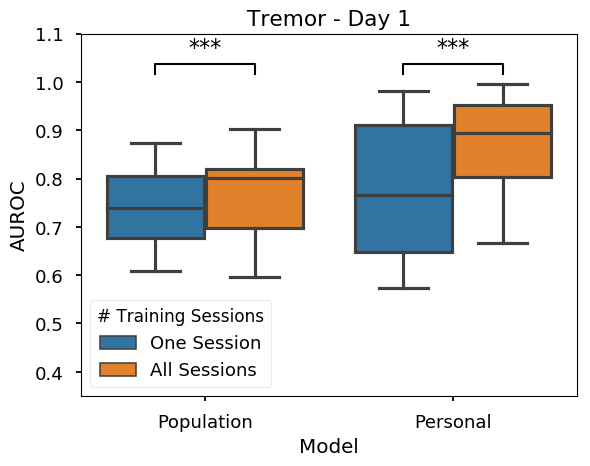

In [13]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Tremor - Day 1');
plt.ylim(0.35,1.1);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Tremor Day 1 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Tremor Day 1 Comparison.png'),format='png',dpi=1000)

## Tremor - Compare Day 2, 1 sessions and all sessions for training, test on remaining

In [14]:
global_one = np.load(os.path.join(results_path,'GLOB_tremor_train1lovo.npy'))[1]
# global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_tremor_train6lovo.npy'))[1]
# global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_tremor_train1lovo.npy'))[1]
# person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_tremor_train5lovo.npy'))[1]
# person_all = np.asarray(person_all)[~np.isnan(person_all)]

In [15]:
print(np.shape(person_one))
print(np.shape(person_all))
print(np.shape(global_one))
print(np.shape(global_all))

(11,)
(11,)
(19,)
(19,)


In [16]:
person_all = np.append(person_all,(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan))
person_one = np.append(person_one,(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan))

In [17]:
_, pvalue1 = stats.ttest_rel(global_one,global_all,nan_policy='omit')
_, pvalue2 = stats.ttest_rel(person_one,person_all,nan_policy='omit')
print('Tremor Day 2\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Tremor Day 2

Population Model p-value: 0.000385, mean improvement: 0.034584
Personal Model p-value: 0.210448, mean improvement: 0.057183


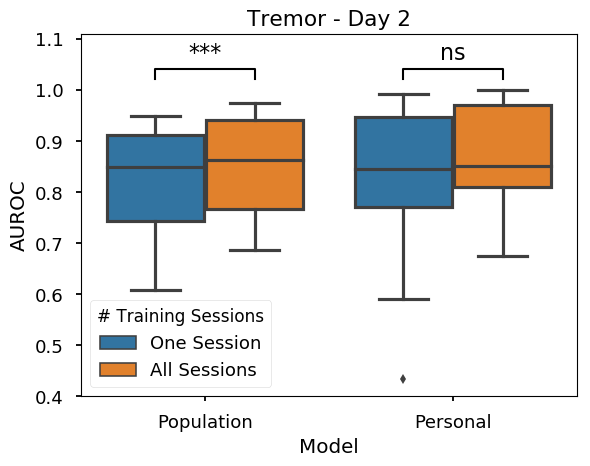

In [18]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Tremor - Day 2');
plt.ylim(0.4,1.11);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Tremor Day 2 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Tremor Day 2 Comparison.png'),format='png',dpi=1000)

## Sensor Analysis

In [432]:
# filename = 'Features_AllLocs_HP+LP_GyroLP.h5'
filename = 'Features_AllLocs_HP.h5'
Data = pd.read_hdf(os.path.join(features_path,filename))
print(Data.shape)
print(len(Data))
Data

(47618, 17)
47618


,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.019006525697428164, 0.039233270371908005, 0...","[10.273506428273729, 2.706283216342912, 5.0615...","[0.0322785855858077, 0.03794236823734332, 0.01...","[3.3542937389248966, 1.068554488586077, 9.3107...","[0.008648494676531003, 0.010948975300842198, 0...","[2.7635771865880097, 1.922690587454126, 4.2009...","[0.0122164607654984, 0.00664163061640281, 0.00...","[0.005869301231487146, 0.012435841625305243, 0...","[0.0052683505768607785, 0.011996108435784742, ...","[0.8215614656047298, 1.1265178529231297, 0.664..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.016870239857220543, 0.038880784586027915, 0...","[10.66239472590443, 2.6287032265762083, 4.4656...","[0.03152207640023257, 0.03700602511294292, 0.0...","[6.017896678147171, 1.937458692248415, 8.78307...","[0.008127107885758364, 0.0103311505086218, 0.0...","[3.3284323758047036, 2.822697515889742, 5.3517...","[0.010626645669058962, 0.006257554464780335, 0...","[0.006126147240407635, 0.011528781024626076, 0...","[0.00550158599667163, 0.01151751507797242, 0.0...","[0.7898793130704667, 3.3456375775178198, 0.722..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.014983230096445938, 0.034245089539097696, 0...","[9.008067810874358, 2.1913443809962745, 4.1487...","[0.026767623824815425, 0.03255297700959554, 0....","[5.907732542989079, 1.9781136013006269, 7.6456...","[0.007308936013999306, 0.009998904210536399, 0...","[2.6885012576952496, 2.8744981875353393, 4.437...","[0.009801355639564385, 0.00597036114953965, 0....","[0.005770113495390447, 0.009879252567247023, 0...","[0.005607636524409158, 0.009855736889137743, 0...","[0.7058148993143553, 3.472527979175533, 0.7433..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018536443737401213, 0.03832482904349985, 0....","[9.19704928911273, 2.470238328817465, 5.191160...","[0.03231517521518697, 0.0351376902372115, 0.01...","[3.3291825611840142, 1.2237696427589757, 9.129...","[0.007891898682657222, 0.011164138169256906, 0...","[2.499042347499924, 1.2004465412231244, 4.3006...","[0.012370743231278975, 0.006549813970182376, 0...","[0.005864085363106116, 0.013165295661291213, 0...","[0.005362517732456273, 0.01281924307169171, 0....","[0.7541402229259171, 1.430995228538481, 0.7466..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018041758375086033, 0.040494936989535574, 0...","[9.574205482842476, 2.41849860452593, 5.094296...","[0.03401907215774285, 0.038726339344342435, 0....","[4.506917875678114, 2.088683714469444, 8.52156...","[0.007895338060772061, 0.010228556827101937, 0...","[3.261874206390144, 2.9412816369694337, 4.6892...","[0.011069607558498772, 0.006669541371605966, 0...","[0.005874228204502195, 0.012111654594136495, 0...","[0.00640904323000902, 0.012160001865619986, 0....","[0.8274834438067099, 2.65230166410693, 0.86461..."
5,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018048433190808826, 0.03880970069646285, 0....","[10.037762711867458, 2.755017250622706, 4.9170...","[0.033230583094526256, 0.03755698378495847, 0....","[6.1045117887930695, 2.6387759746159203, 8.524...","[0.0068918688267811555, 0.009739683788607695, ...","[2.815085865907445, 3.5249854492605253, 4.0164...","[0.010864299384545745, 0.00576118202326969, 0....","[0.0055198770572464795, 0.011220709600591237, ...","[0.006417288624931243, 0.011095821640517601, 0...","[0.800175119239338, 3.310748157349315, 0.93396..."
6,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.020510536797407726, 0.041588541729696726, 0...","[10.795100630378583, 3.066031907430774, 5.3709...","[0.03476283086173651, 0.0413332645618924, 0.02...","[5.50753749195438, 2.066507348606009, 9.658463...","[0.008

In [433]:
#filter empty rows on all locations
for s in Data.columns.values[7:]:
    print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
    Data = Data[Data[s].apply(type) != float]
    
print(Data.shape)
Data

anterior_thigh__accel,discarded 6051 rows
anterior_thigh__gyro,discarded 0 rows
distal_lateral_shank__accel,discarded 3 rows
distal_lateral_shank__gyro,discarded 0 rows
dorsal_hand__accel,discarded 3 rows
dorsal_hand__gyro,discarded 0 rows
flexor_digitorum__accel,discarded 331 rows
medial_chest_accel,discarded 9 rows
sacrum_accel,discarded 2 rows
sacrum_gyro,discarded 0 rows
(41219, 17)


,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.019006525697428164, 0.039233270371908005, 0...","[10.273506428273729, 2.706283216342912, 5.0615...","[0.0322785855858077, 0.03794236823734332, 0.01...","[3.3542937389248966, 1.068554488586077, 9.3107...","[0.008648494676531003, 0.010948975300842198, 0...","[2.7635771865880097, 1.922690587454126, 4.2009...","[0.0122164607654984, 0.00664163061640281, 0.00...","[0.005869301231487146, 0.012435841625305243, 0...","[0.0052683505768607785, 0.011996108435784742, ...","[0.8215614656047298, 1.1265178529231297, 0.664..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.016870239857220543, 0.038880784586027915, 0...","[10.66239472590443, 2.6287032265762083, 4.4656...","[0.03152207640023257, 0.03700602511294292, 0.0...","[6.017896678147171, 1.937458692248415, 8.78307...","[0.008127107885758364, 0.0103311505086218, 0.0...","[3.3284323758047036, 2.822697515889742, 5.3517...","[0.010626645669058962, 0.006257554464780335, 0...","[0.006126147240407635, 0.011528781024626076, 0...","[0.00550158599667163, 0.01151751507797242, 0.0...","[0.7898793130704667, 3.3456375775178198, 0.722..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.014983230096445938, 0.034245089539097696, 0...","[9.008067810874358, 2.1913443809962745, 4.1487...","[0.026767623824815425, 0.03255297700959554, 0....","[5.907732542989079, 1.9781136013006269, 7.6456...","[0.007308936013999306, 0.009998904210536399, 0...","[2.6885012576952496, 2.8744981875353393, 4.437...","[0.009801355639564385, 0.00597036114953965, 0....","[0.005770113495390447, 0.009879252567247023, 0...","[0.005607636524409158, 0.009855736889137743, 0...","[0.7058148993143553, 3.472527979175533, 0.7433..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018536443737401213, 0.03832482904349985, 0....","[9.19704928911273, 2.470238328817465, 5.191160...","[0.03231517521518697, 0.0351376902372115, 0.01...","[3.3291825611840142, 1.2237696427589757, 9.129...","[0.007891898682657222, 0.011164138169256906, 0...","[2.499042347499924, 1.2004465412231244, 4.3006...","[0.012370743231278975, 0.006549813970182376, 0...","[0.005864085363106116, 0.013165295661291213, 0...","[0.005362517732456273, 0.01281924307169171, 0....","[0.7541402229259171, 1.430995228538481, 0.7466..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018041758375086033, 0.040494936989535574, 0...","[9.574205482842476, 2.41849860452593, 5.094296...","[0.03401907215774285, 0.038726339344342435, 0....","[4.506917875678114, 2.088683714469444, 8.52156...","[0.007895338060772061, 0.010228556827101937, 0...","[3.261874206390144, 2.9412816369694337, 4.6892...","[0.011069607558498772, 0.006669541371605966, 0...","[0.005874228204502195, 0.012111654594136495, 0...","[0.00640904323000902, 0.012160001865619986, 0....","[0.8274834438067099, 2.65230166410693, 0.86461..."
5,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018048433190808826, 0.03880970069646285, 0....","[10.037762711867458, 2.755017250622706, 4.9170...","[0.033230583094526256, 0.03755698378495847, 0....","[6.1045117887930695, 2.6387759746159203, 8.524...","[0.0068918688267811555, 0.009739683788607695, ...","[2.815085865907445, 3.5249854492605253, 4.0164...","[0.010864299384545745, 0.00576118202326969, 0....","[0.0055198770572464795, 0.011220709600591237, ...","[0.006417288624931243, 0.011095821640517601, 0...","[0.800175119239338, 3.310748157349315, 0.93396..."
6,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.020510536797407726, 0.041588541729696726, 0...","[10.795100630378583, 3.066031907430774, 5.3709...","[0.03476283086173651, 0.0413332645618924, 0.02...","[5.50753749195438, 2.066507348606009, 9.658463...","[0.008

In [431]:
Data

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.019006525697428164, 0.039233270371908005, 0...","[10.273506428273729, 2.706283216342912, 5.0615...","[0.0322785855858077, 0.03794236823734332, 0.01...","[3.3542937389248966, 1.068554488586077, 9.3107...","[0.008648494676531003, 0.010948975300842198, 0...","[2.7635771865880097, 1.922690587454126, 4.2009...","[0.0122164607654984, 0.00664163061640281, 0.00...","[0.005869301231487146, 0.012435841625305243, 0...","[0.0052683505768607785, 0.011996108435784742, ...","[0.8215614656047298, 1.1265178529231297, 0.664..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.016870239857220543, 0.038880784586027915, 0...","[10.66239472590443, 2.6287032265762083, 4.4656...","[0.03152207640023257, 0.03700602511294292, 0.0...","[6.017896678147171, 1.937458692248415, 8.78307...","[0.008127107885758364, 0.0103311505086218, 0.0...","[3.3284323758047036, 2.822697515889742, 5.3517...","[0.010626645669058962, 0.006257554464780335, 0...","[0.006126147240407635, 0.011528781024626076, 0...","[0.00550158599667163, 0.01151751507797242, 0.0...","[0.7898793130704667, 3.3456375775178198, 0.722..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.014983230096445938, 0.034245089539097696, 0...","[9.008067810874358, 2.1913443809962745, 4.1487...","[0.026767623824815425, 0.03255297700959554, 0....","[5.907732542989079, 1.9781136013006269, 7.6456...","[0.007308936013999306, 0.009998904210536399, 0...","[2.6885012576952496, 2.8744981875353393, 4.437...","[0.009801355639564385, 0.00597036114953965, 0....","[0.005770113495390447, 0.009879252567247023, 0...","[0.005607636524409158, 0.009855736889137743, 0...","[0.7058148993143553, 3.472527979175533, 0.7433..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018536443737401213, 0.03832482904349985, 0....","[9.19704928911273, 2.470238328817465, 5.191160...","[0.03231517521518697, 0.0351376902372115, 0.01...","[3.3291825611840142, 1.2237696427589757, 9.129...","[0.007891898682657222, 0.011164138169256906, 0...","[2.499042347499924, 1.2004465412231244, 4.3006...","[0.012370743231278975, 0.006549813970182376, 0...","[0.005864085363106116, 0.013165295661291213, 0...","[0.005362517732456273, 0.01281924307169171, 0....","[0.7541402229259171, 1.430995228538481, 0.7466..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018041758375086033, 0.040494936989535574, 0...","[9.574205482842476, 2.41849860452593, 5.094296...","[0.03401907215774285, 0.038726339344342435, 0....","[4.506917875678114, 2.088683714469444, 8.52156...","[0.007895338060772061, 0.010228556827101937, 0...","[3.261874206390144, 2.9412816369694337, 4.6892...","[0.011069607558498772, 0.006669541371605966, 0...","[0.005874228204502195, 0.012111654594136495, 0...","[0.00640904323000902, 0.012160001865619986, 0....","[0.8274834438067099, 2.65230166410693, 0.86461..."
5,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018048433190808826, 0.03880970069646285, 0....","[10.037762711867458, 2.755017250622706, 4.9170...","[0.033230583094526256, 0.03755698378495847, 0....","[6.1045117887930695, 2.6387759746159203, 8.524...","[0.0068918688267811555, 0.009739683788607695, ...","[2.815085865907445, 3.5249854492605253, 4.0164...","[0.010864299384545745, 0.00576118202326969, 0....","[0.0055198770572464795, 0.011220709600591237, ...","[0.006417288624931243, 0.011095821640517601, 0...","[0.800175119239338, 3.310748157349315, 0.93396..."
6,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.020510536797407726, 0.041588541729696726, 0...","[10.795100630378583, 3.066031907430774, 5.3709...","[0.03476283086173651, 0.0413332645618924, 0.02...","[5.50753749195438, 2.066507348606009, 9.658463...","[0.008

In [54]:
def featureUnpack(Data, sensor_list):
    #unpack features
    colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

    colnames1=[i+'acc' for i in colnames]
    colnames2=[i+'gyr' for i in colnames]
    colnames=colnames1+colnames2
    
    Datafinal = pd.DataFrame()

    for i in range(len(Data)):
        Datatemp=pd.DataFrame()
        for sensors in sensor_list:
            if sensors!="flexor_digitorum_":
                F1 = Data[sensors + '_accel'].iloc[i]
                F2 = Data[sensors + '_gyro'].iloc[i]
                F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames])
                Datatemp=pd.concat((Datatemp,F),axis=1)
            else:
                F1 = Data[sensors + '_accel'].iloc[i]
                F = pd.DataFrame(data=F1.reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames1])
                Datatemp=pd.concat((Datatemp,F),axis=1)
        Datafinal = pd.concat((Datafinal,Datatemp),axis=0)
        
    Datafinal=Datafinal.reset_index(drop=True)
    Data=Data.reset_index(drop=True)
    Datafinal = pd.concat((Data.iloc[:,:7],Datafinal),axis=1)
        
    return Datafinal

In [55]:
# sensor_list = ['anterior_thigh_','dorsal_hand_','sacrum']
sensor_list = [['dorsal_hand_'],['flexor_digitorum_'],
               ['anterior_thigh_'],['dorsal_hand_','flexor_digitorum_','anterior_thigh_']] # just hand sensors

In [57]:
sensor_list = ['flexor_digitorum_']

Rows w Tremor 8692/41219 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.328, rec=0.245, Spec=0.950, auroc_train=1.000, auroc=0.806

Subj/Visit 1, prec=0.722, rec=0.092, Spec=0.973, auroc_train=1.000, auroc=0.786

Subj/Visit 2, prec=0.570, rec=0.275, Spec=0.981, auroc_train=1.000, auroc=0.810

Subj/Visit 3, prec=0.129, rec=0.284, Spec=0.919, auroc_train=1.000, auroc=0.706

Subj/Visit 4, prec=0.118, rec=0.474, Spec=0.879, auroc_train=1.000, auroc=0.771

Subj/Visit 5, prec=0.500, rec=0.072, Spec=0.977, auroc_train=1.000, auroc=0.691

Subj/Visit 6, prec=0.665, rec=0.332, Spec=0.896, auroc_train=1.000, auroc=0.762

Subj/Visit 7, prec=0.842, rec=0.432, Spec=0.995, auroc_train=1.000, auroc=0.910

Subj/Visit 8, prec=0.723, rec=0.358, Spec=0.995, auroc_train=1.000, auroc=0.920

Subj/Visit 9, prec=0.948, rec=0.287, Spec=0.982, auroc_train=1.000, auroc=0.799

Subj/Visit 10, prec=0.280, rec=0.595, Spec=0.948, auroc_train=1.000, auroc=0.941

Subj/Visit 11, prec=0.263, rec=0.055, Spec=0.963, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.038, rec=0.200, Spec=0.972, auroc_train=1.000, auroc=0.928

Subj/Visit 18, prec=0.931, rec=0.126, Spec=0.967, auroc_train=1.000, auroc=0.609

Subj/Visit 19, prec=0.916, rec=0.310, Spec=0.900, auroc_train=1.000, auroc=0.708
f1_test=0.262+/-0.188, prec=0.448+/-0.338, rec=0.239+/-0.172, auprc=0.407+/-0.295, auroc=0.786+/-0.095
Hand 0.7856176557560082 (0.7385548580324811, 0.8326804534795352)


C:\Users\Public\Documents\Anaconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Rows w Tremor 8692/41219 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.157, rec=0.114, Spec=0.938, auroc_train=1.000, auroc=0.748

Subj/Visit 1, prec=0.769, rec=0.040, Spec=0.991, auroc_train=1.000, auroc=0.738

Subj/Visit 2, prec=0.517, rec=0.174, Spec=0.985, auroc_train=1.000, auroc=0.779

Subj/Visit 3, prec=0.143, rec=0.125, Spec=0.968, auroc_train=1.000, auroc=0.720

Subj/Visit 4, prec=0.157, rec=0.333, Spec=0.938, auroc_train=1.000, auroc=0.737

Subj/Visit 5, prec=0.310, rec=0.114, Spec=0.920, auroc_train=1.000, auroc=0.618

Subj/Visit 6, prec=0.616, rec=0.273, Spec=0.894, auroc_train=1.000, auroc=0.717

Subj/Visit 7, prec=0.547, rec=0.468, Spec=0.978, auroc_train=1.000, auroc=0.938

Subj/Visit 8, prec=0.510, rec=0.516, Spec=0.983, auroc_train=1.000, auroc=0.897

Subj/Visit 9, prec=0.918, rec=0.238, Spec=0.976, auroc_train=1.000, auroc=0.776

Subj/Visit 10, prec=0.441, rec=0.608, Spec=0.974, auroc_train=1.000, auroc=0.951

Subj/Visit 11, prec=0.412, rec=0.018, Spec=0.994, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.114, rec=0.400, Spec=0.983, auroc_train=1.000, auroc=0.975

Subj/Visit 18, prec=0.914, rec=0.075, Spec=0.975, auroc_train=1.000, auroc=0.681

Subj/Visit 19, prec=0.931, rec=0.190, Spec=0.950, auroc_train=1.000, auroc=0.690
f1_test=0.234+/-0.161, prec=0.426+/-0.311, rec=0.243+/-0.172, auprc=0.392+/-0.282, auroc=0.781+/-0.118
Forearm 0.781205248125117 (0.7227344817837507, 0.8396760144664834)


C:\Users\Public\Documents\Anaconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Rows w Tremor 8692/41219 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.096, rec=0.120, Spec=0.886, auroc_train=1.000, auroc=0.555

Subj/Visit 1, prec=0.750, rec=0.009, Spec=0.998, auroc_train=1.000, auroc=0.601

Subj/Visit 2, prec=0.308, rec=0.022, Spec=0.995, auroc_train=1.000, auroc=0.735

Subj/Visit 3, prec=0.188, rec=0.239, Spec=0.956, auroc_train=1.000, auroc=0.694

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.983, auroc_train=1.000, auroc=0.525

Subj/Visit 5, prec=0.523, rec=0.184, Spec=0.947, auroc_train=1.000, auroc=0.726

Subj/Visit 6, prec=0.852, rec=0.025, Spec=0.997, auroc_train=1.000, auroc=0.642

Subj/Visit 7, prec=0.407, rec=0.396, Spec=0.968, auroc_train=1.000, auroc=0.875

Subj/Visit 8, prec=0.077, rec=0.053, Spec=0.978, auroc_train=1.000, auroc=0.564

Subj/Visit 9, prec=0.795, rec=0.105, Spec=0.970, auroc_train=1.000, auroc=0.623

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.573

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.997, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.977, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=0.663

Subj/Visit 18, prec=0.850, rec=0.138, Spec=0.915, auroc_train=1.000, auroc=0.520

Subj/Visit 19, prec=0.855, rec=0.037, Spec=0.978, auroc_train=1.000, auroc=0.524
f1_test=0.095+/-0.114, prec=0.326+/-0.351, rec=0.076+/-0.101, auprc=0.293+/-0.284, auroc=0.623+/-0.142
Thigh 0.6226516843658972 (0.5523640954878024, 0.6929392732439921)


C:\Users\Public\Documents\Anaconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Rows w Tremor 8692/41219 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.308, rec=0.261, Spec=0.941, auroc_train=1.000, auroc=0.790

Subj/Visit 1, prec=0.604, rec=0.029, Spec=0.985, auroc_train=1.000, auroc=0.729

Subj/Visit 2, prec=0.584, rec=0.449, Spec=0.970, auroc_train=1.000, auroc=0.889

Subj/Visit 3, prec=0.185, rec=0.307, Spec=0.943, auroc_train=1.000, auroc=0.681

Subj/Visit 4, prec=0.137, rec=0.421, Spec=0.909, auroc_train=1.000, auroc=0.770

Subj/Visit 5, prec=0.510, rec=0.136, Spec=0.959, auroc_train=1.000, auroc=0.745

Subj/Visit 6, prec=0.749, rec=0.135, Spec=0.972, auroc_train=1.000, auroc=0.706

Subj/Visit 7, prec=0.840, rec=0.613, Spec=0.993, auroc_train=1.000, auroc=0.950

Subj/Visit 8, prec=0.558, rec=0.253, Spec=0.993, auroc_train=1.000, auroc=0.887

Subj/Visit 9, prec=0.936, rec=0.186, Spec=0.986, auroc_train=1.000, auroc=0.788

Subj/Visit 10, prec=0.177, rec=0.149, Spec=0.977, auroc_train=1.000, auroc=0.902

Subj/Visit 11, prec=0.200, rec=0.008, Spec=0.992, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.105, rec=0.200, Spec=0.991, auroc_train=1.000, auroc=0.903

Subj/Visit 18, prec=0.860, rec=0.134, Spec=0.923, auroc_train=1.000, auroc=0.627

Subj/Visit 19, prec=0.897, rec=0.203, Spec=0.918, auroc_train=1.000, auroc=0.657
f1_test=0.228+/-0.179, prec=0.428+/-0.333, rec=0.205+/-0.156, auprc=0.405+/-0.295, auroc=0.779+/-0.132
Combo 0.7785379539366086 (0.713379553137145, 0.8436963547360723)


C:\Users\Public\Documents\Anaconda\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


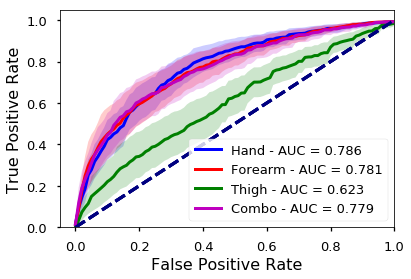

In [58]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'
res_all = pd.DataFrame()

fileNameList = ['Hand', 'Forearm', 'Thigh', 'Combo']
AX = None

for x,sList in zip(range(len(sensor_list)),sensor_list):
    SData = featureUnpack(Data,sList)
    
    X = SData.iloc[:,7:].as_matrix()
    fnames = SData.iloc[:,7:].columns.values

    indp = ((SData[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = SData.Subject.as_matrix()

    res,res_group = LOSOCV(SData,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
    AUC = res_group['Random Forest']['auroc']
    
    
    save_object(res_group,symptom+fileNameList[x]+'DataResults')
    
    T = 'Random Forest'
    NanInds = []
    for i in range(len(res_group[T]['auroc'])):
        if np.isnan(res_group[T]['auroc'][i]):
            NanInds.append(i)
    for i in sorted(NanInds,reverse=True):
        del res_group[T]['tpr'][i]
        del res_group[T]['auroc'][i]
    
    print(fileNameList[x],np.mean(AUC),
          stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
    
    cols = ['b','r','g','m','k']
    
    if AX==None:
        AX = plot_roc(res_group['Random Forest']['tpr'], res_group['Random Forest']['fpr'][0], 
                      np.nanmean(res_group['Random Forest']['auroc']),plotname=fileNameList[x],col=cols[x])
    else:
        plot_roc(res_group['Random Forest']['tpr'], res_group['Random Forest']['fpr'][0], 
                      np.nanmean(res_group['Random Forest']['auroc']),ax=AX,plotname=fileNameList[x],col=cols[x])
        
plt.savefig('Results/'+symptom+'SensorsRF.tiff',format='tiff',dpi=1000)
plt.savefig('Results/'+symptom+'SensorsRF.png',format='png',dpi=1000)

# EMG + Accel Forearm

In [261]:
filename = 'Features_AllLocs_HP.h5'
Data_accel = pd.read_hdf(os.path.join(features_path,filename))
for s in Data_accel.columns.values[7:]:
    print('%s,discarded %d rows'%(s,sum(Data_accel[s].apply(type) == float)))
    Data_accel = Data_accel[Data_accel[s].apply(type) != float]
Data_accel

anterior_thigh__accel,discarded 6051 rows
anterior_thigh__gyro,discarded 0 rows
distal_lateral_shank__accel,discarded 3 rows
distal_lateral_shank__gyro,discarded 0 rows
dorsal_hand__accel,discarded 3 rows
dorsal_hand__gyro,discarded 0 rows
flexor_digitorum__accel,discarded 331 rows
medial_chest_accel,discarded 9 rows
sacrum_accel,discarded 2 rows
sacrum_gyro,discarded 0 rows


,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,anterior_thigh__accel,anterior_thigh__gyro,distal_lateral_shank__accel,distal_lateral_shank__gyro,dorsal_hand__accel,dorsal_hand__gyro,flexor_digitorum__accel,medial_chest_accel,sacrum_accel,sacrum_gyro
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.019006525697428164, 0.039233270371908005, 0...","[10.273506428273729, 2.706283216342912, 5.0615...","[0.0322785855858077, 0.03794236823734332, 0.01...","[3.3542937389248966, 1.068554488586077, 9.3107...","[0.008648494676531003, 0.010948975300842198, 0...","[2.7635771865880097, 1.922690587454126, 4.2009...","[0.0122164607654984, 0.00664163061640281, 0.00...","[0.005869301231487146, 0.012435841625305243, 0...","[0.0052683505768607785, 0.011996108435784742, ...","[0.8215614656047298, 1.1265178529231297, 0.664..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.016870239857220543, 0.038880784586027915, 0...","[10.66239472590443, 2.6287032265762083, 4.4656...","[0.03152207640023257, 0.03700602511294292, 0.0...","[6.017896678147171, 1.937458692248415, 8.78307...","[0.008127107885758364, 0.0103311505086218, 0.0...","[3.3284323758047036, 2.822697515889742, 5.3517...","[0.010626645669058962, 0.006257554464780335, 0...","[0.006126147240407635, 0.011528781024626076, 0...","[0.00550158599667163, 0.01151751507797242, 0.0...","[0.7898793130704667, 3.3456375775178198, 0.722..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.014983230096445938, 0.034245089539097696, 0...","[9.008067810874358, 2.1913443809962745, 4.1487...","[0.026767623824815425, 0.03255297700959554, 0....","[5.907732542989079, 1.9781136013006269, 7.6456...","[0.007308936013999306, 0.009998904210536399, 0...","[2.6885012576952496, 2.8744981875353393, 4.437...","[0.009801355639564385, 0.00597036114953965, 0....","[0.005770113495390447, 0.009879252567247023, 0...","[0.005607636524409158, 0.009855736889137743, 0...","[0.7058148993143553, 3.472527979175533, 0.7433..."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018536443737401213, 0.03832482904349985, 0....","[9.19704928911273, 2.470238328817465, 5.191160...","[0.03231517521518697, 0.0351376902372115, 0.01...","[3.3291825611840142, 1.2237696427589757, 9.129...","[0.007891898682657222, 0.011164138169256906, 0...","[2.499042347499924, 1.2004465412231244, 4.3006...","[0.012370743231278975, 0.006549813970182376, 0...","[0.005864085363106116, 0.013165295661291213, 0...","[0.005362517732456273, 0.01281924307169171, 0....","[0.7541402229259171, 1.430995228538481, 0.7466..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018041758375086033, 0.040494936989535574, 0...","[9.574205482842476, 2.41849860452593, 5.094296...","[0.03401907215774285, 0.038726339344342435, 0....","[4.506917875678114, 2.088683714469444, 8.52156...","[0.007895338060772061, 0.010228556827101937, 0...","[3.261874206390144, 2.9412816369694337, 4.6892...","[0.011069607558498772, 0.006669541371605966, 0...","[0.005874228204502195, 0.012111654594136495, 0...","[0.00640904323000902, 0.012160001865619986, 0....","[0.8274834438067099, 2.65230166410693, 0.86461..."
5,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.018048433190808826, 0.03880970069646285, 0....","[10.037762711867458, 2.755017250622706, 4.9170...","[0.033230583094526256, 0.03755698378495847, 0....","[6.1045117887930695, 2.6387759746159203, 8.524...","[0.0068918688267811555, 0.009739683788607695, ...","[2.815085865907445, 3.5249854492605253, 4.0164...","[0.010864299384545745, 0.00576118202326969, 0....","[0.0055198770572464795, 0.011220709600591237, ...","[0.006417288624931243, 0.011095821640517601, 0...","[0.800175119239338, 3.310748157349315, 0.93396..."
6,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,"[0.020510536797407726, 0.041588541729696726, 0...","[10.795100630378583, 3.066031907430774, 5.3709...","[0.03476283086173651, 0.0413332645618924, 0.02...","[5.50753749195438, 2.066507348606009, 9.658463...","[0.008

In [218]:
def feature_unpack_forearm(Data_accel):
    #unpack features
    colnames_accel =['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']
    colnames_accel =[i+' accel' for i in colnames_accel]

    sensor = 'flexor_digitorum_accel'
    
    Datafinal = pd.DataFrame()
    
    for i in range(len(Data_accel)):
        F = Data_accel[sensor].iloc[i]
        #F = pd.DataFrame(data=F.reshape(-1,1).T,index=[i],columns=colnames_accel)
        F = pd.DataFrame(data=F.reshape(-1,1).T,index=[i],columns=colnames_accel)
        Datafinal = pd.concat((Datafinal,F))
    Datafinal=Datafinal.reset_index(drop=True)
    Data_accel=Data_accel.reset_index(drop=True)
    Datafinal = pd.concat((Data_accel.iloc[:,:7],Datafinal),axis=1)

    return Datafinal

In [219]:
Data_accel = feature_unpack_forearm(Data_accel)

AttributeError: 'float' object has no attribute 'reshape'

In [168]:
Data_accel.tail()

,0,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSX accel,RMSY accel,...,PSD_std accel,PSD_skew accel,PSD_kur accel,jerk_mean accel,jerk_std accel,jerk_skew accel,jerk_kur accel,Sen_X accel,Sen_Y accel,Sen_Z accel
41214,7,1056,2 Weeks: Time 120,right,Motor #13: Sitting,NaN,NaN,1.0,0.000756,0.001058,...,0.000112,2.480539,6.614404,-0.000088,0.010061,0.261020,4.983528,0.770035,0.842293,0.655539
41215,8,1056,2 Weeks: Time 120,right,Motor #13: Sitting,NaN,NaN,1.0,0.000557,0.000850,...,0.000017,3.116517,11.617471,-0.000036,0.011299,0.511576,9.462263,0.960000,1.054269,0.839141
41216,9,1056,2 Weeks: Time 120,right,Motor #13: Sitting,NaN,NaN,1.0,0.001991,0.003523,...,0.000533,5.525855,30.196535,0.000207,0.044735,0.044237,43.658105,0.397813,0.404568,0.516139
41217,10,1056,2 Weeks: Time 120,right,Motor #13: Sitting,NaN,NaN,1.0,0.002045,0.003850,...,0.000692,2.692805,6.492793,0.000083,0.046165,2.787701,40.841017,0.701813,0.892608,0.744100
41218,11,1056,2 Weeks: Time 120,right,Motor #13: Sitting,NaN,NaN,1.0,0.001430,0.002583,...,0.000033,1.478250,1.845717,-0.000104,0.026797,-0.042824,1.629782,0.922530,1.333361,1.059622


In [153]:
Data_EMG = pd.read_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv',index_col=0)
for s in Data_EMG.columns.values[4:]:
    print('%s,discarded %d rows'%(s,sum(np.isnan(Data_EMG[s]))))
    Data_EMG = Data_EMG[~np.isnan(Data_EMG[s])]
Data_EMG.head()

Bradykinesia,discarded 9933 rows
Tremor,discarded 41 rows
RMS,discarded 0 rows
range,discarded 0 rows
mean,discarded 0 rows
var,discarded 0 rows
skew,discarded 0 rows
kurt,discarded 0 rows
Pdom_rel,discarded 0 rows
Dom_freq,discarded 0 rows
Sen,discarded 0 rows
PSD_mean,discarded 0 rows
PSD_std,discarded 0 rows
PSD_skew,discarded 0 rows
PSD_kurt,discarded 0 rows


,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMS,range,mean,var,skew,kurt,Pdom_rel,Dom_freq,Sen,PSD_mean,PSD_std,PSD_skew,PSD_kurt
0,1004,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,1.0,0.0,6.151822e-07,0.000602,0.000014,0.000041,7.179695,66.654490,0.241702,23.428116,0.135976,3.161790e-12,2.189881e-12,1.668629,2.143981
1,1004,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,1.0,0.0,3.699207e-07,0.000386,0.000009,0.000024,9.214391,110.152090,0.142971,54.665604,0.311380,2.171009e-12,1.097601e-12,0.209320,-1.729422
2,1004,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,1.0,0.0,3.354660e-07,0.000386,0.000007,0.000023,11.376146,155.119490,0.171759,62.481236,0.323161,2.162332e-12,1.454878e-12,0.370689,-1.425093
3,1004,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,1.0,0.0,7.853895e-08,0.000024,0.000004,0.000004,1.518726,2.345251,0.125203,31.240618,1.458165,8.563463e-14,2.210345e-14,0.236476,-0.540804
4,1004,2 Weeks: Time 0,Motor #2: Walking,flexor_digitorum_left,1.0,0.0,1.074996e-07,0.000069,0.000005,0.000006,4.309193,30.842093,0.161547,58.570290,0.933010,1.281437e-13,4.491813e-14,1.401989,1.535325


In [185]:
Datafinal = pd.DataFrame()

for i in range(len(Data_EMG)):
    if (i%2000) == 0:
        print('%d of %d'%(i,len(Data_EMG)))
    
    row = Data_EMG.iloc[i]
    clip = Data_EMG.index[i]
    #print('clip: ' + str(clip))
    subj = row['Subject']
    #print('subj: ' + str(subj))
    visit = row['Visit']
    #print('visit: ' + visit)
    task = row['Task']
    #print('task: ' + task)
    side = row['Location'][17:]
    #print('side: ' + side)
    
    features_EMG = row[6:]
    EMG_cols = list(features_EMG.index)
    for j in range(len(EMG_cols)):
        EMG_cols[j] = EMG_cols[j] + ' elec'
    
    d_acc = Data_accel.loc[(Data_accel.Subject==subj) & (Data_accel.Visit==visit) & (Data_accel.Task==task) & (Data_accel.Side==side) & (Data_accel[0]==clip)]
    try:
        features_accel = d_acc.iloc[0][8:]
    except:
        continue
    data = np.concatenate((features_EMG.values,features_accel.values))
    cols = np.concatenate((EMG_cols,features_accel.index))
    #Datatemp = pd.DataFrame(data=np.hstack((features_EMG,features_accel)).reshape(-1,1).T,index=[i],columns=cols)
    #Datafinal = pd.concat((Datafinal,Datatemp),axis=0)
    F = pd.DataFrame(data=data.reshape(-1,1).T,columns=cols)
    Datafinal = pd.concat((Datafinal,F))

Datafinal=Datafinal.reset_index(drop=True)
Data=Data_EMG.reset_index(drop=True)
Datafinal = pd.concat((Data.iloc[:,:6],Datafinal),axis=1)

for s in Datafinal.columns.values[6:]:
    Datafinal = Datafinal[Datafinal[s].apply(type) != float]

0 of 37546
2000 of 37546
4000 of 37546
6000 of 37546
8000 of 37546
10000 of 37546
12000 of 37546
14000 of 37546
16000 of 37546
18000 of 37546
20000 of 37546
22000 of 37546
24000 of 37546
26000 of 37546
28000 of 37546
30000 of 37546
32000 of 37546
34000 of 37546
36000 of 37546


In [188]:
Datafinal.tail()

,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMS elec,range elec,mean elec,var elec,...,PSD_std accel,PSD_skew accel,PSD_kur accel,jerk_mean accel,jerk_std accel,jerk_skew accel,jerk_kur accel,Sen_X accel,Sen_Y accel,Sen_Z accel
31761,1053,2 Weeks: Time 120,Motor #7: Drawing on Paper,flexor_digitorum_right,1.0,0.0,3.99117e-07,0.000193842,1.80416e-05,2.16578e-05,...,0.000755889,1.80145,3.52108,0.000241702,0.0770516,-0.170171,0.407524,0.892542,0.754606,1.1757
31762,1053,2 Weeks: Time 120,Motor #7: Drawing on Paper,flexor_digitorum_right,1.0,0.0,4.66318e-07,0.00023311,1.98903e-05,2.62494e-05,...,0.00933681,3.70467,12.8039,-0.000191174,0.0682122,-0.0507099,0.321579,0.891091,0.725987,1.10239
31763,1053,2 Weeks: Time 120,Motor #7: Drawing on Paper,flexor_digitorum_right,1.0,0.0,4.98922e-07,0.00023311,2.26888e-05,2.696e-05,...,0.00522389,3.84479,15.4914,-0.000104378,0.0712783,0.243184,1.65185,0.844785,0.877309,1.01925
31764,1053,2 Weeks: Time 120,Motor #7: Drawing on Paper,flexor_digitorum_right,1.0,0.0,3.78161e-07,0.000163225,1.82352e-05,1.95138e-05,...,0.00781931,4.46658,19.1047,0.000976545,0.109905,0.429381,3.83934,0.721532,0.835993,1.03387
31765,1053,2 Weeks: Time 120,Motor #7: Drawing on Paper,flexor_digitorum_right,1.0,0.0,2.87542e-07,0.000101382,1.30169e-05,1.55901e-05,...,0.00653788,3.31654,12.9803,-0.000285826,0.114196,0.49921,4.04333,0.697731,0.729844,1.0169


In [211]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafinal.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 7448/31766 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.088, rec=0.011, Spec=0.982, auroc_train=1.000, auroc=0.542

Subj/Visit 1, prec=0.636, rec=0.006, Spec=0.996, auroc_train=1.000, auroc=0.576

Subj/Visit 2, prec=0.203, rec=0.042, Spec=0.970, auroc_train=1.000, auroc=0.580

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.977, auroc_train=1.000, auroc=0.371

Subj/Visit 4, prec=1.000, rec=0.029, Spec=1.000, auroc_train=1.000, auroc=0.456

Subj/Visit 5, prec=0.129, rec=0.006, Spec=0.981, auroc_train=1.000, auroc=0.496

Subj/Visit 6, prec=0.312, rec=0.010, Spec=0.982, auroc_train=1.000, auroc=0.518

Subj/Visit 7, prec=0.130, rec=0.010, Spec=0.988, auroc_train=1.000, auroc=0.414

Subj/Visit 8, prec=0.312, rec=0.022, Spec=0.996, auroc_train=1.000, auroc=0.575

Subj/Visit 9, prec=0.600, rec=0.006, Spec=0.991, auroc_train=1.000, auroc=0.479

Subj/Visit 10, prec=0.121, rec=0.035, Spec=0.973, auroc_train=1.000, auroc=0.452

Subj/Visit 11, prec=0.250, rec=0.006, Spec=0.996, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [109]:
Data = Datafinal.copy() #original unmodified dataframe
groups = Data.Subject.as_matrix()
groups

array([1004, 1004, 1004, ..., 1053, 1053, 1053], dtype=int64)

In [212]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Data_accel.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,8:].as_matrix()
fnames = Data.iloc[:,8:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 8692/37839 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.193, rec=0.185, Spec=0.918, auroc_train=1.000, auroc=0.730

Subj/Visit 1, prec=0.768, rec=0.054, Spec=0.987, auroc_train=1.000, auroc=0.714

Subj/Visit 2, prec=0.390, rec=0.180, Spec=0.973, auroc_train=1.000, auroc=0.763

Subj/Visit 3, prec=0.179, rec=0.216, Spec=0.956, auroc_train=1.000, auroc=0.700

Subj/Visit 4, prec=0.528, rec=0.333, Spec=0.919, auroc_train=1.000, auroc=0.744

Subj/Visit 5, prec=0.376, rec=0.127, Spec=0.927, auroc_train=1.000, auroc=0.623

Subj/Visit 6, prec=0.621, rec=0.283, Spec=0.886, auroc_train=1.000, auroc=0.703

Subj/Visit 7, prec=0.542, rec=0.577, Spec=0.971, auroc_train=1.000, auroc=0.921

Subj/Visit 8, prec=0.515, rec=0.526, Spec=0.982, auroc_train=1.000, auroc=0.900

Subj/Visit 9, prec=0.906, rec=0.268, Spec=0.966, auroc_train=1.000, auroc=0.775

Subj/Visit 10, prec=0.392, rec=0.689, Spec=0.962, auroc_train=1.000, auroc=0.953

Subj/Visit 11, prec=0.406, rec=0.034, Spec=0.987, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.974, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.091, rec=0.500, Spec=0.971, auroc_train=1.000, auroc=0.954

Subj/Visit 18, prec=0.935, rec=0.101, Spec=0.970, auroc_train=1.000, auroc=0.650

Subj/Visit 19, prec=0.959, rec=0.213, Spec=0.961, auroc_train=1.000, auroc=0.699
f1_test=0.263+/-0.165, prec=0.444+/-0.304, rec=0.290+/-0.202, auprc=0.421+/-0.283, auroc=0.766+/-0.111
Elapsed time = 3.397 min


In [213]:
t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafinal.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,19:].as_matrix()
fnames = Data.iloc[:,19:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

Rows w Tremor 7448/31766 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.019, rec=0.004, Spec=0.970, auroc_train=1.000, auroc=0.481

Subj/Visit 1, prec=0.667, rec=0.007, Spec=0.996, auroc_train=1.000, auroc=0.544

Subj/Visit 2, prec=0.154, rec=0.026, Spec=0.974, auroc_train=1.000, auroc=0.526

Subj/Visit 3, prec=0.038, rec=0.023, Spec=0.961, auroc_train=1.000, auroc=0.399

Subj/Visit 4, prec=0.500, rec=0.014, Spec=0.995, auroc_train=1.000, auroc=0.426

Subj/Visit 5, prec=0.259, rec=0.010, Spec=0.986, auroc_train=1.000, auroc=0.482

Subj/Visit 6, prec=0.115, rec=0.003, Spec=0.981, auroc_train=1.000, auroc=0.498

Subj/Visit 7, prec=0.033, rec=0.003, Spec=0.983, auroc_train=1.000, auroc=0.429

Subj/Visit 8, prec=0.217, rec=0.022, Spec=0.993, auroc_train=1.000, auroc=0.491

Subj/Visit 9, prec=0.308, rec=0.003, Spec=0.987, auroc_train=1.000, auroc=0.491

Subj/Visit 10, prec=0.065, rec=0.015, Spec=0.977, auroc_train=1.000, auroc=0.485

Subj/Visit 11, prec=1.000, rec=0.009, Spec=1.000, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [192]:
subj_list = ([1004,1016,1018,1019,1020,1024,1029,1030,1032,1038,1044,1046,1047,1049,1051,1052,1053,1054,1055,1056])
task_list = ['Motor #2: Walking', 'Motor #3: Walking while Counting','Motor #4: Finger to Nose',
             'Motor #5: Alternating Hand Movements','Motor #6: Sit to Stand','Motor #7: Drawing on Paper',
             'Motor #8: Typing on a Computer','Motor #9: Nuts and Bolts','Motor #10: Drinking Water',
             'Motor #11: Organizing Folder','Motor #12: Folding Towels','Motor #1: Standing','Motor #13: Sitting']

In [209]:
subj = 1024
visit = '2 Weeks: Time 0'
task = task_list[7]
side = 'right'
loc = 'flexor_digitorum_' + side

In [210]:
a = Data_accel.loc[(Data_accel.Subject==subj) & (Data_accel.Visit==visit) & (Data_accel.Task==task) & (Data_accel.Side==side)]
e = Data_EMG.loc[(Data_EMG.Subject==subj) & (Data_EMG.Visit==visit) & (Data_EMG.Task==task) & (Data_EMG.Location==loc)]
f = Datafinal.loc[(Datafinal.Subject==subj) & (Datafinal.Visit==visit) & (Datafinal.Task==task) & (Datafinal.Location==loc)]
print(a.iloc[0]['Tremor'])
print(e.iloc[0]['Tremor'])
print(f.iloc[0]['Tremor'])

1.0
1.0
1.0


# Forearm Analysis Method 2

In [5]:
Data_accel = pd.read_hdf(os.path.join(features_path,'Features_AllLocs_HP.h5'))
Data_EMG = pd.read_csv('Z:CIS-PD Study\MotorTasks EMG Data.csv',index_col=0).iloc[:,6:]

#EMG_cols = list(Data_EMG.columns)
#for j in range(len(EMG_cols)):
#    EMG_cols[j] = EMG_cols[j] + ' elec'
#Data_EMG.columns = EMG_cols

Datafull = pd.DataFrame
Data_accel = Data_accel.reset_index(drop=True)
Data_EMG = Data_EMG.reset_index(drop=True)
Datafull = pd.concat((Data_accel.iloc[:,:6],Data_EMG,Data_accel.iloc[:,13]),axis=1)

In [6]:
Datafull.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,RMS0,mean0,var0,skew0,...,MAV9,RMS10,mean10,var10,skew10,kurt10,binen10,energy10,MAV10,flexor_digitorum__accel
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0122164607654984, 0.00664163061640281, 0.00..."
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.010626645669058962, 0.006257554464780335, 0..."
2,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.009801355639564385, 0.00597036114953965, 0...."
3,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.000058,0.000129,0.000009,0.399398,...,0.000002,1.818105e-08,4.014991e-09,9.088620e-07,-0.036244,1.759811,2.024107,2.064290e-09,6.495575e-07,"[0.012370743231278975, 0.006549813970182376, 0..."
4,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.011069607558498772, 0.006669541371605966, 0..."


In [7]:
s = 'flexor_digitorum__accel'
print('%s,discarded %d rows'%(s,sum(Datafull[s].apply(type) == float)))
Datafull = Datafull[Datafull[s].apply(type) != float]

s = 'Tremor'
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]

s = Data_EMG.columns.values[6]
print('%s,discarded %d rows'%(s,sum(np.isnan(Datafull[s]))))
Datafull = Datafull[~np.isnan(Datafull[s])]
    
#Datafull=Datafull[Datafull.Subject!=1020] #remove subj does not have visits 1-5

flexor_digitorum__accel,discarded 6358 rows
Tremor,discarded 3384 rows
energy0,discarded 18271 rows


In [8]:
def feature_unpack_forearm(Datafull):
    #unpack features
    colnames_accel =['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']
    colnames_accel =[i+' accel' for i in colnames_accel]

    sensor = 'flexor_digitorum__accel'
    
    Datafinal = pd.DataFrame()
    
    for i in range(len(Datafull)):
        F = Datafull[sensor].iloc[i]
        F = pd.DataFrame(data=F.reshape(-1,1).T,index=[i],columns=colnames_accel)
        Datafinal = pd.concat((Datafinal,F))
    Datafinal=Datafinal.reset_index(drop=True)
    Datafull=Datafull.reset_index(drop=True)
    Datafinal = pd.concat((Datafull.iloc[:,:94],Datafinal),axis=1)

    return Datafinal

In [9]:
Datafull = feature_unpack_forearm(Datafull)

In [10]:
Datafull.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,RMS0,mean0,var0,skew0,...,PSD_std accel,PSD_skew accel,PSD_kur accel,jerk_mean accel,jerk_std accel,jerk_skew accel,jerk_kur accel,Sen_X accel,Sen_Y accel,Sen_Z accel
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.000058,0.000129,0.000009,0.399398,...,0.001444,2.382094,5.333100,0.000575,0.054457,0.551808,1.459770,0.574293,0.741461,0.783992
1,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000056,0.000124,0.000011,-0.347647,...,0.002467,3.798906,15.633740,-0.000238,0.057850,0.941721,3.168144,0.644744,0.786910,0.878338
2,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000060,0.000134,0.000014,0.958786,...,0.001858,3.593627,13.813865,0.002097,0.046613,0.998875,3.229052,0.650181,0.715376,0.908934
3,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000057,0.000126,0.000012,0.254498,...,0.002840,1.330189,0.418690,0.000635,0.057558,-0.139625,1.690948,0.622565,0.677374,0.750162
4,1004,4 Weeks,left,Motor #2: Walking,0.0,0.0,0.000053,0.000117,0.000013,0.216862,...,0.005875,1.849822,2.488761,-0.002750,0.065912,0.191875,2.691909,0.652863,0.642245,0.760753


In [40]:
#LOSO Combined

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4087/19605 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.378, rec=0.185, Spec=0.960, auroc_train=1.000, auroc=0.785

Subj/Visit 1, prec=0.724, rec=0.025, Spec=0.992, auroc_train=1.000, auroc=0.661

Subj/Visit 2, prec=0.556, rec=0.143, Spec=0.991, auroc_train=1.000, auroc=0.851

Subj/Visit 3, prec=0.059, rec=0.018, Spec=0.987, auroc_train=1.000, auroc=0.638

Subj/Visit 4, prec=0.875, rec=0.200, Spec=0.991, auroc_train=1.000, auroc=0.807

Subj/Visit 5, prec=0.353, rec=0.063, Spec=0.967, auroc_train=1.000, auroc=0.663

Subj/Visit 6, prec=0.610, rec=0.172, Spec=0.949, auroc_train=1.000, auroc=0.687

Subj/Visit 7, prec=0.528, rec=0.388, Spec=0.983, auroc_train=1.000, auroc=0.908

Subj/Visit 8, prec=0.370, rec=0.354, Spec=0.976, auroc_train=1.000, auroc=0.919

Subj/Visit 9, prec=0.644, rec=0.102, Spec=0.960, auroc_train=1.000, auroc=0.691

Subj/Visit 10, prec=0.462, rec=0.267, Spec=0.980, auroc_train=1.000, auroc=0.910

Subj/Visit 11, prec=0.720, rec=0.058, Spec=0.993, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.988, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.043, rec=0.286, Spec=0.960, auroc_train=1.000, auroc=0.913

Subj/Visit 18, prec=0.958, rec=0.128, Spec=0.979, auroc_train=1.000, auroc=0.699

Subj/Visit 19, prec=0.923, rec=0.116, Spec=0.961, auroc_train=1.000, auroc=0.636
f1_test=0.179+/-0.125, prec=0.460+/-0.318, rec=0.159+/-0.135, auprc=0.398+/-0.257, auroc=0.762+/-0.113
Elapsed time = 2.762 min


In [41]:
#LOSO EMG

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4087/19605 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.991, auroc_train=1.000, auroc=0.589

Subj/Visit 1, prec=0.200, rec=0.001, Spec=0.996, auroc_train=1.000, auroc=0.581

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=0.524

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.451

Subj/Visit 4, prec=1.000, rec=0.029, Spec=1.000, auroc_train=1.000, auroc=0.582

Subj/Visit 5, prec=0.167, rec=0.005, Spec=0.993, auroc_train=1.000, auroc=0.583

Subj/Visit 6, prec=0.333, rec=0.005, Spec=0.995, auroc_train=1.000, auroc=0.544

Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.453

Subj/Visit 8, prec=0.077, rec=0.021, Spec=0.990, auroc_train=1.000, auroc=0.557

Subj/Visit 9, prec=0.259, rec=0.019, Spec=0.962, auroc_train=1.000, auroc=0.543

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=0.442

Subj/Visit 11, prec=0.333, rec=0.010, Spec=0.994, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.998, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.000, rec=0.000, Spec=0.989, auroc_train=1.000, auroc=0.378

Subj/Visit 18, prec=0.857, rec=0.023, Spec=0.986, auroc_train=1.000, auroc=0.548

Subj/Visit 19, prec=1.000, rec=0.002, Spec=1.000, auroc_train=1.000, auroc=0.450
f1_test=0.013+/-0.017, prec=0.225+/-0.326, rec=0.007+/-0.009, auprc=0.243+/-0.248, auroc=0.492+/-0.081
Elapsed time = 2.498 min


In [42]:
#LOSO Accel

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,94:].as_matrix()
fnames = Data.iloc[:,94:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 4087/19605 = 0.21
Training Random Forest

Subj/Visit 0, prec=0.286, rec=0.130, Spec=0.957, auroc_train=1.000, auroc=0.783

Subj/Visit 1, prec=0.814, rec=0.058, Spec=0.988, auroc_train=1.000, auroc=0.715

Subj/Visit 2, prec=0.618, rec=0.300, Spec=0.986, auroc_train=1.000, auroc=0.868

Subj/Visit 3, prec=0.195, rec=0.140, Spec=0.973, auroc_train=1.000, auroc=0.674

Subj/Visit 4, prec=0.778, rec=0.400, Spec=0.964, auroc_train=1.000, auroc=0.818

Subj/Visit 5, prec=0.392, rec=0.105, Spec=0.954, auroc_train=1.000, auroc=0.667

Subj/Visit 6, prec=0.570, rec=0.206, Spec=0.928, auroc_train=1.000, auroc=0.707

Subj/Visit 7, prec=0.556, rec=0.510, Spec=0.980, auroc_train=1.000, auroc=0.939

Subj/Visit 8, prec=0.553, rec=0.542, Spec=0.983, auroc_train=1.000, auroc=0.892

Subj/Visit 9, prec=0.781, rec=0.202, Spec=0.960, auroc_train=1.000, auroc=0.751

Subj/Visit 10, prec=0.611, rec=0.489, Spec=0.980, auroc_train=1.000, auroc=0.942

Subj/Visit 11, prec=0.810, rec=0.054, Spec=0.996, au

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.968, auroc_train=1.000, auroc=nan

Subj/Visit 17, prec=0.143, rec=0.714, Spec=0.973, auroc_train=1.000, auroc=0.975

Subj/Visit 18, prec=0.945, rec=0.161, Spec=0.965, auroc_train=1.000, auroc=0.684

Subj/Visit 19, prec=0.958, rec=0.219, Spec=0.961, auroc_train=1.000, auroc=0.682
f1_test=0.277+/-0.164, prec=0.503+/-0.303, rec=0.269+/-0.198, auprc=0.455+/-0.242, auroc=0.792+/-0.114
Elapsed time = 1.570 min


In [16]:
Data_sit_stand = Datafull.loc[(Datafull.Task=='Motor #1: Standing') | (Datafull.Task=='Motor #13: Sitting')]
Data_sit_stand.head()

,Subject,Visit,Side,Task,Tremor,Bradykinesia,RMS0,mean0,var0,skew0,...,PSD_std accel,PSD_skew accel,PSD_kur accel,jerk_mean accel,jerk_std accel,jerk_skew accel,jerk_kur accel,Sen_X accel,Sen_Y accel,Sen_Z accel
676,1004,2 Weeks: Time 0,left,Motor #1: Standing,0.0,NaN,0.000283,0.000610,0.000164,-0.645819,...,3.830452e-04,4.296489,17.627531,0.001824,0.022806,-0.576625,3.456233,0.099328,0.354210,0.726217
677,1004,2 Weeks: Time 0,left,Motor #1: Standing,0.0,NaN,0.000382,0.000841,0.000152,-0.296346,...,6.953389e-07,1.625836,2.125096,0.000009,0.005208,-0.071361,-0.088730,1.304056,1.392910,1.379972
678,1004,2 Weeks: Time 30,left,Motor #1: Standing,0.0,NaN,0.000351,0.000756,0.000208,0.834853,...,1.288278e-03,1.764447,2.353005,0.000495,0.037564,-0.275627,2.319282,0.388398,0.639460,0.547811
679,1004,2 Weeks: Time 30,left,Motor #1: Standing,0.0,NaN,0.000211,0.000467,0.000061,-1.425732,...,7.830217e-03,5.101922,26.625453,-0.000013,0.028360,0.719088,6.129235,0.120552,0.143662,0.397182
680,1004,2 Weeks: Time 30,left,Motor #1: Standing,0.0,NaN,0.000327,0.000705,0.000197,-0.314906,...,2.279406e-05,4.150825,18.859875,-0.000110,0.006534,-0.033044,17.814817,0.807115,1.070351,0.954768


In [43]:
#LOSO Sitting and Standing Combined

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Data_sit_stand.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:].as_matrix()
fnames = Data.iloc[:,6:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 377/3376 = 0.11
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.706


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.960, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.469


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.840, auroc_train=1.000, auroc=0.327


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 10, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 11, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.731


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=0.000, rec=0.000, Spec=0.953, auroc_train=1.000, auroc=nan

Subj/Visit 13, prec=1.000, rec=0.432, Spec=1.000, auroc_train=1.000, auroc=0.907


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.973, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 17, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 18, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.646

Subj/Visit 19, prec=1.000, rec=0.216, Spec=1.000, auroc_train=1.000, auroc=0.620
f1_test=0.048+/-0.149, prec=0.100+/-0.300, rec=0.032+/-0.103, auprc=0.507+/-0.358, auroc=0.629+/-0.174
Elapsed time = 0.310 min


In [44]:
#LOSO Sitting and StandingEMG

t1=time.time()
res_all = pd.DataFrame()

symptom = 'Tremor'

Data = Data_sit_stand.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()] #remove nan rows for current symptom
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,6:94].as_matrix()
fnames = Data.iloc[:,6:94].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
model_name = ['Random Forest']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 377/3376 = 0.11
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.982, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.560


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.399


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.850, auroc_train=1.000, auroc=0.347


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 10, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 11, prec=0.000, rec=0.000, Spec=0.926, auroc_train=1.000, auroc=0.371


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 12, prec=0.000, rec=0.000, Spec=0.883, auroc_train=1.000, auroc=nan

Subj/Visit 13, prec=0.444, rec=0.049, Spec=0.933, auroc_train=1.000, auroc=0.610


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 14, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 15, prec=0.000, rec=0.000, Spec=0.980, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 16, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 17, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 18, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.425

Subj/Visit 19, prec=1.000, rec=0.027, Spec=1.000, auroc_train=1.000, auroc=0.593
f1_test=0.007+/-0.022, prec=0.072+/-0.234, rec=0.004+/-0.012, auprc=0.367+/-0.302, auroc=0.472+/-0.103
Elapsed time = 0.304 min


In [45]:
#LOVO Combined

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

tremor_res_all,tremor_res_visit_all =  res_all, res_visit_all

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.684


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.850
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.972, auroc_train=1.000, auroc=0.713
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.431+/-0.301, auroc=0.749+/-0.072
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.802, rec=0.762, Spec=0.815, auroc_train=1.000, auroc=0.865

Subj/Visit 1, prec=0.912, rec=0.820, Spec=0.893, auroc_train=1.000, auroc=0.936

Subj/Visit 2, prec=0.900, rec=0.800, Spec=0.907, auroc_train=1.000, auroc=0.918

Subj/Visit 3, prec=0.903, rec=0.783, Spec=0.900, auroc_train=1.000, auroc=0.934

Subj/Visit 4, prec=0.899, rec=0.892, Spec=0.873, auroc_train=1.000, auroc=0.947

Subj/Visit 5, prec=0.929, rec=0.755, Spec=0.917, auroc_train=1.000, auroc=0.904


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.496, auroc_train=1.000, auroc=nan
f1_test=0.723+/-0.297, prec=0.763+/-0.314, rec=0.688+/-0.284, auprc=0.920+/-0.031, auroc=0.917+/-0.027
Subject 1018
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.860

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.429, Spec=1.000, auroc_train=1.000, auroc=0.999

Subj/Visit 3, prec=1.000, rec=0.312, Spec=1.000, auroc_train=1.000, auroc=0.878

Subj/Visit 4, prec=1.000, rec=0.250, Spec=1.000, auroc_train=1.000, auroc=0.719

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.556, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.599+/-0.327, prec=0.857+/-0.350, rec=0.507+/-0.350, auprc=0.793+/-0.245, auroc=0.922+/-0.101
Subject 1019
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.549

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=0.500, rec=1.000, Spec=0.994, auroc_train=1.000, auroc=0.994

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.977, auroc_train=1.000, auroc=0.932


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.995


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.940

Subj/Visit 6, prec=1.000, rec=0.100, Spec=1.000, auroc_train=1.000, auroc=0.730
f1_test=0.264+/-0.376, prec=0.357+/-0.440, rec=0.300+/-0.444, auprc=0.453+/-0.322, auroc=0.877+/-0.160
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0, prec=0.692, rec=0.132, Spec=0.957, auroc_train=1.000, auroc=0.714

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.981, auroc_train=1.000, auroc=0.450

Subj/Visit 2, prec=0.037, rec=0.167, Spec=0.783, auroc_train=1.000, auroc=0.704

Subj/Visit 3, prec=1.000, rec=0.086, Spec=1.000, auroc_train=1.000, auroc=0.763

Subj/Visit 4, prec=0.500, rec=0.462, Spec=0.940, auroc_train=1.000, auroc=0.916
only 1 class in test data - cannot compute roc curve


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.922, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.833, rec=0.208, Spec=0.990, auroc_train=1.000, auroc=0.898
f1_test=0.179+/-0.167, prec=0.438+/-0.394, rec=0.151+/-0.146, auprc=0.466+/-0.300, auroc=0.741+/-0.154
Subject 1029
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.295, Spec=1.000, auroc_train=1.000, auroc=0.839

Subj/Visit 1, prec=0.273, rec=0.529, Spec=0.827, auroc_train=1.000, auroc=0.775

Subj/Visit 2, prec=0.123, rec=0.571, Spec=0.689, auroc_train=1.000, auroc=0.628

Subj/Visit 3, prec=0.839, rec=0.342, Spec=0.934, auroc_train=1.000, auroc=0.731

Subj/Visit 4, prec=0.636, rec=0.618, Spec=0.911, auroc_train=1.000, auroc=0.906

Subj/Visit 5, prec=0.385, rec=0.152, Spec=0.931, auroc_train=1.000, auroc=0.696

Subj/Visit 6, prec=0.722, rec=0.149, Spec=0.951, auroc_train=1.000, auroc=0.660
f1_test=0.371+/-0.148, prec=0.568+/-0.295, rec=0.379+/-0.181, auprc=0.534+/-0.285, auroc=0.748+/-0.092
Subject 1030
Training Random Fo

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.994

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.100, Spec=1.000, auroc_train=1.000, auroc=0.980


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.981

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.984, auroc_train=1.000, auroc=0.971
f1_test=0.264+/-0.376, prec=0.429+/-0.495, rec=0.229+/-0.357, auprc=0.627+/-0.358, auroc=0.938+/-0.121
Subject 1032
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.859

Subj/Visit 1, prec=1.000, rec=0.417, Spec=1.000, auroc_train=1.000, auroc=0.890

Subj/Visit 2, prec=1.000, rec=0.600, Spec=1.000, auroc_train=1.000, auroc=0.994


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.500

Subj/Visit 4, prec=0.286, rec=1.000, Spec=0.970, auroc_train=1.000, auroc=0.999

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=0.960
f1_test=0.398+/-0.378, prec=0.469+/-0.469, rec=0.431+/-0.420, auprc=0.588+/-0.359, auroc=0.886+/-0.166
Subject 1038
Training Random Forest

Subj/Visit 0, prec=0.830, rec=0.629, Spec=0.871, auroc_train=1.000, auroc=0.872

Subj/Visit 1, prec=0.630, rec=0.723, Spec=0.796, auroc_train=1.000, auroc=0.802

Subj/Visit 2, prec=0.585, rec=0.689, Spec=0.718, auroc_train=1.000, auroc=0.809

Subj/Visit 3, prec=0.804, rec=0.569, Spec=0.844, auroc_train=1.000, auroc=0.728

Subj/Visit 4, prec=0.852, rec=0.590, Spec=0.931, auroc_train=1.000, auroc=0.898

Subj/Visit 5, prec=0.648, rec=0.761, Spec=0.762, auroc_train=1.000, auroc=0.892

Subj/Visit 6, prec=0.705, rec=0.596, Spec=0.827, a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.979


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.150+/-0.128, auroc=0.934+/-0.044
Subject 1049
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0, prec=0.807, rec=0.523, Spec=0.904, auroc_train=1.000, auroc=0.750

Subj/Visit 1, prec=0.951, rec=0.591, Spec=0.964, auroc_train=1.000, auroc=0.847

Subj/Visit 2, prec=0.974, rec=0.673, Spec=0.955, auroc_train=1.000, auroc=0.936

Subj/Visit 3, prec=0.522, rec=0.462, Spec=0.928, auroc_train=1.000, auroc=0.809

Subj/Visit 4, prec=0.533, rec=0.500, Spec=0.909, auroc_train=1.000, auroc=0.826

Subj/Visit 5, prec=0.821, rec=0.464, Spec=0.943, auroc_train=1.000, auroc=0.776

Subj/Visit 6, prec=0.810, rec=0.468, Spec=0.859, auroc_train=1.000, auroc=0.769
f1_test=0.622+/-0.102, prec=0.774+/-0.168, rec=0.526+/-0.074, auprc=0.749+/-0.152, auroc=0.816+/-0.058
Subject 1051
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.674


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.148, Spec=1.000, auroc_train=1.000, auroc=0.573


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.043+/-0.096, prec=0.167+/-0.373, rec=0.025+/-0.055, auprc=0.406+/-0.099, auroc=0.624+/-0.051
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:99: Runti

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0, prec=0.929, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.555

Subj/Visit 1, prec=0.650, rec=0.823, Spec=0.054, auroc_train=1.000, auroc=0.352

Subj/Visit 2, prec=0.548, rec=0.895, Spec=0.097, auroc_train=1.000, auroc=0.524

Subj/Visit 3, prec=0.955, rec=0.875, Spec=0.667, auroc_train=1.000, auroc=0.896

Subj/Visit 4, prec=0.775, rec=0.972, Spec=0.130, auroc_train=1.000, auroc=0.831

Subj/Visit 5, prec=0.979, rec=0.896, Spec=0.000, auroc_train=1.000, auroc=0.741
f1_test=0.847+/-0.107, prec=0.806+/-0.163, rec=0.910+/-0.059, auprc=0.842+/-0.173, auroc=0.650+/-0.189
Subject 1056
Tra

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.909, rec=0.982, Spec=0.000, auroc_train=1.000, auroc=0.318
f1_test=0.798+/-0.223, prec=0.741+/-0.296, rec=0.962+/-0.038, auprc=0.766+/-0.259, auroc=0.541+/-0.178


In [46]:
#LOVO EMG

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,6:94]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

tremor_res_all,tremor_res_visit_all =  res_all, res_visit_all

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.501


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.992, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.989, auroc_train=1.000, auroc=0.386
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.981, auroc_train=1.000, auroc=0.588
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.298+/-0.301, auroc=0.492+/-0.083
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.779, rec=0.779, Spec=0.782, auroc_train=1.000, auroc=0.844

Subj/Visit 1, prec=0.813, rec=0.719, Spec=0.777, auroc_train=1.000, auroc=0.819

Subj/Visit 2, prec=0.793, rec=0.681, Spec=0.814, auroc_train=1.000, auroc=0.801

Subj/Visit 3, prec=0.840, rec=0.734, Spec=0.833, auroc_train=1.000, auroc=0.865

Subj/Visit 4, prec=0.841, rec=0.799, Spec=0.809, auroc_train=1.000, auroc=0.872

Subj/Visit 5, prec=0.786, rec=0.523, Spec=0.798, auroc_train=1.000, auroc=0.784


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.472, auroc_train=1.000, auroc=nan
f1_test=0.644+/-0.269, prec=0.693+/-0.284, rec=0.605+/-0.261, auprc=0.815+/-0.040, auroc=0.831+/-0.032
Subject 1018
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.550


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.593


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.471


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.577


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.729


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.794


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.408
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.091+/-0.047, auroc=0.589+/-0.125
Subject 1019
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=0.516


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.756


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.924


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.885


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.712


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.612


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.589
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.077+/-0.043, auroc=0.713+/-0.141
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0, prec=0.857, rec=0.176, Spec=0.978, auroc_train=1.000, auroc=0.664

Subj/Visit 1, prec=0.286, rec=0.200, Spec=0.951, auroc_train=1.000, auroc=0.522

Subj/Visit 2, prec=0.095, rec=0.333, Spec=0.842, auroc_train=1.000, auroc=0.669

Subj/Visit 3, prec=0.571, rec=0.057, Spec=0.941, auroc_train=1.000, auroc=0.734

Subj/Visit 4, prec=0.273, rec=0.231, Spec=0.920, auroc_train=1.000, auroc=0.813
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.845, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 6, prec=0.583, rec=0.292, Spec=0.950, auroc_train=1.000, auroc=0.867
f1_test=0.203+/-0.119, prec=0.381+/-0.281, rec=0.184+/-0.111, auprc=0.406+/-0.253, auroc=0.712+/-0.112
Subject 1029
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.125, Spec=1.000, auroc_train=1.000, auroc=0.719

Subj/Visit 1, prec=0.062, rec=0.118, Spec=0.784, auroc_train=1.000, auroc=0.389

Subj/Visit 2, prec=0.051, rec=0.143, Spec=0.798, auroc_train=1.000, auroc=0.471

Subj/Visit 3, prec=0.560, rec=0.184, Spec=0.855, auroc_train=1.000, auroc=0.511

Subj/Visit 4, prec=0.393, rec=0.324, Spec=0.874, auroc_train=1.000, auroc=0.650

Subj/Visit 5, prec=0.211, rec=0.121, Spec=0.871, auroc_train=1.000, auroc=0.601

Subj/Visit 6, prec=0.524, rec=0.126, Spec=0.902, auroc_train=1.000, auroc=0.584
f1_test=0.196+/-0.094, prec=0.400+/-0.310, rec=0.163+/-0.069, auprc=0.387+/-0.256, auroc=0.561+/-0.104
Subject 1030
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.802

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.691


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.567

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.879


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.586

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.236


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.607
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.079+/-0.041, auroc=0.624+/-0.191
Subject 1032
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.578

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.993, auroc_train=1.000, auroc=0.690


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.792


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.279


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.476


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.937

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=0.513
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.058+/-0.047, auroc=0.609+/-0.201
Subject 1038
Training Random Forest

Subj/Visit 0, prec=0.889, rec=0.571, Spec=0.929, auroc_train=1.000, auroc=0.743

Subj/Visit 1, prec=0.702, rec=0.702, Spec=0.857, auroc_train=1.000, auroc=0.728

Subj/Visit 2, prec=0.674, rec=0.689, Spec=0.808, auroc_train=1.000, auroc=0.745

Subj/Visit 3, prec=0.618, rec=0.472, Spec=0.672, auroc_train=1.000, auroc=0.567

Subj/Visit 4, prec=0.727, rec=0.615, Spec=0.845, auroc_train=1.000, auroc=0.731

Subj/Visit 5, prec=0.892, rec=0.717, Spec=0.950, auroc_train=1.000, auroc=0.894

Subj/Visit 6, prec=0.651, rec=0.538, Spec=0.800, auroc_train=1.000, auroc=0.648
f1_test=0.667+/-0.077, prec=0.736+/-0.103, rec=0.615+/-0.086, auprc=0.694+/-0.105, auroc=0.722+/-0.093
Subject 1044
Training Random 

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.667

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.789


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.455

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.655


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.636

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.679
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.091+/-0.018, auroc=0.643+/-0.092
Subject 1046
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.100, rec=0.040, Spec=0.944, auroc_train=1.000, auroc=0.614

Subj/Visit 1, prec=0.533, rec=0.163, Spec=0.956, auroc_train=1.000, auroc=0.771

Subj/Visit 2, prec=0.333, rec=0.219, Spec=0.905, auroc_train=1.000, auroc=0.714

Subj/Visit 3, prec=0.368, rec=0.219, Spec=0.915, auroc_train=1.000, auroc=0.686

Subj/Visit 4, prec=0.750, rec=0.259, Spec=0.966, auroc_train=1.000, auroc=0.839

Subj/Visit 5, prec=0.778, rec=0.230, Spec=0.974, auroc_train=1.000, auroc=0.799

Subj/Visit 6, prec=0.615, rec=0.143, Spec=0.962, auroc_train=1.000, auroc=0.691
f1_test=0.260+/-0.098, prec=0.497+/-0.226, rec=0.182+/-0.069, auprc=0.425+/-0.158, auroc=0.730+/-0.071
Subject 1047
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.447
only 1 class in test data - cannot compute roc curve


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.453


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.012+/-0.008, auroc=0.450+/-0.003
Subject 1049
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0, prec=0.435, rec=0.307, Spec=0.693, auroc_train=1.000, auroc=0.460

Subj/Visit 1, prec=0.595, rec=0.379, Spec=0.691, auroc_train=1.000, auroc=0.564

Subj/Visit 2, prec=0.789, rec=0.273, Spec=0.818, auroc_train=1.000, auroc=0.519

Subj/Visit 3, prec=0.255, rec=0.500, Spec=0.752, auroc_train=1.000, auroc=0.658

Subj/Visit 4, prec=0.300, rec=0.281, Spec=0.864, auroc_train=1.000, auroc=0.657

Subj/Visit 5, prec=0.367, rec=0.159, Spec=0.846, auroc_train=1.000, auroc=0.582

Subj/Visit 6, prec=0.489, rec=0.211, Spec=0.718, auroc_train=1.000, auroc=0.518
f1_test=0.339+/-0.074, prec=0.462+/-0.171, rec=0.301+/-0.104, auprc=0.457+/-0.173, auroc=0.565+/-0.069
Subject 1051
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda


Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.517


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.500, rec=0.037, Spec=0.994, auroc_train=1.000, auroc=0.432


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.011+/-0.026, prec=0.083+/-0.186, rec=0.006+/-0.014, auprc=0.295+/-0.098, auroc=0.474+/-0.043
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:99: Runti

only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0, prec=0.925, rec=0.943, Spec=0.000, auroc_train=1.000, auroc=0.176

Subj/Visit 1, prec=0.664, rec=0.924, Spec=0.000, auroc_train=1.000, auroc=0.276

Subj/Visit 2, prec=0.544, rec=0.974, Spec=0.000, auroc_train=1.000, auroc=0.258

Subj/Visit 3, prec=0.886, rec=0.969, Spec=0.000, auroc_train=1.000, auroc=0.431

Subj/Visit 4, prec=0.753, rec=0.986, Spec=0.000, auroc_train=1.000, auroc=0.336

Subj/Visit 5, prec=0.978, rec=0.840, Spec=0.000, auroc_train=1.000, auroc=0.274
f1_test=0.848+/-0.086, prec=0.792+/-0.153, rec=0.939+/-0.049, auprc=0.721+/-0.196, auroc=0.292+/-0.078
Subject 1056
Tra

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.917, rec=0.982, Spec=0.091, auroc_train=1.000, auroc=0.598
f1_test=0.800+/-0.220, prec=0.742+/-0.297, rec=0.975+/-0.026, auprc=0.743+/-0.317, auroc=0.566+/-0.065


In [47]:
#LOVO Accel

symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Datafull.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,94:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)

tremor_res_all,tremor_res_visit_all =  res_all, res_visit_all

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.655


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 3, prec=1.000, rec=0.444, Spec=1.000, auroc_train=1.000, auroc=0.949
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.972, auroc_train=1.000, auroc=0.837
f1_test=0.088+/-0.215, prec=0.143+/-0.350, rec=0.063+/-0.156, auprc=0.614+/-0.290, auroc=0.814+/-0.121
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.819, rec=0.779, Spec=0.831, auroc_train=1.000, auroc=0.878

Subj/Visit 1, prec=0.881, rec=0.849, Spec=0.845, auroc_train=1.000, auroc=0.916

Subj/Visit 2, prec=0.859, rec=0.815, Spec=0.860, auroc_train=1.000, auroc=0.913

Subj/Visit 3, prec=0.897, rec=0.727, Spec=0.900, auroc_train=1.000, auroc=0.917

Subj/Visit 4, prec=0.862, rec=0.899, Spec=0.818, auroc_train=1.000, auroc=0.916

Subj/Visit 5, prec=0.904, rec=0.852, Spec=0.872, auroc_train=1.000, auroc=0.922


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.465, auroc_train=1.000, auroc=nan
f1_test=0.723+/-0.297, prec=0.746+/-0.306, rec=0.703+/-0.292, auprc=0.911+/-0.019, auroc=0.910+/-0.015
Subject 1018
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.250, Spec=1.000, auroc_train=1.000, auroc=0.798

Subj/Visit 1, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.375, Spec=1.000, auroc_train=1.000, auroc=0.909

Subj/Visit 4, prec=1.000, rec=0.250, Spec=1.000, auroc_train=1.000, auroc=0.773

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.889, Spec=1.000, auroc_train=1.000, auroc=1.000
f1_test=0.755+/-0.270, prec=1.000+/-0.000, rec=0.681+/-0.341, auprc=0.800+/-0.242, auroc=0.926+/-0.094
Subject 1019
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.479

Subj/Visit 1, prec=1.000, rec=0.667, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.972, auroc_train=1.000, auroc=0.865

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.995, auroc_train=1.000, auroc=0.978

Subj/Visit 5, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.100, Spec=1.000, auroc_train=1.000, auroc=0.687
f1_test=0.378+/-0.399, prec=0.571+/-0.495, rec=0.324+/-0.372, auprc=0.572+/-0.387, auroc=0.858+/-0.188
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.029, Spec=1.000, auroc_train=1.000, auroc=0.856

Subj/Visit 1, prec=0.286, rec=0.200, Spec=0.951, auroc_train=1.000, auroc=0.712

Subj/Visit 2, prec=0.067, rec=0.167, Spec=0.883, auroc_train=1.000, auroc=0.778

Subj/Visit 3, prec=0.889, rec=0.114, 

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.971, auroc_train=1.000, auroc=nan

Subj/Visit 6, prec=0.500, rec=0.125, Spec=0.970, auroc_train=1.000, auroc=0.777
f1_test=0.139+/-0.082, prec=0.423+/-0.363, rec=0.113+/-0.068, auprc=0.403+/-0.288, auroc=0.762+/-0.051
Subject 1029
Training Random Forest

Subj/Visit 0, prec=0.967, rec=0.259, Spec=0.981, auroc_train=1.000, auroc=0.860

Subj/Visit 1, prec=0.350, rec=0.824, Spec=0.813, auroc_train=1.000, auroc=0.849

Subj/Visit 2, prec=0.101, rec=0.714, Spec=0.514, auroc_train=1.000, auroc=0.622

Subj/Visit 3, prec=0.850, rec=0.224, Spec=0.961, auroc_train=1.000, auroc=0.720

Subj/Visit 4, prec=0.606, rec=0.588, Spec=0.904, auroc_train=1.000, auroc=0.889

Subj/Visit 5, prec=0.536, rec=0.455, Spec=0.888, auroc_train=1.000, auroc=0.786

Subj/Visit 6, prec=0.625, rec=0.172, Spec=0.912, auroc_train=1.000, auroc=0.670
f1_test=0.399+/-0.133, prec=0.576+/-0.270, rec=0.462+/-0.237, auprc=0.585+/-0.227

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.807

Subj/Visit 2, prec=1.000, rec=0.167, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.300, Spec=1.000, auroc_train=1.000, auroc=0.990

Subj/Visit 5, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 6, prec=0.600, rec=1.000, Spec=0.968, auroc_train=1.000, auroc=0.985
f1_test=0.627+/-0.358, prec=0.800+/-0.355, rec=0.610+/-0.407, auprc=0.875+/-0.176, auroc=0.968+/-0.066
Subject 1032
Training Random Forest

Subj/Visit 0, prec=0.500, rec=0.250, Spec=0.988, auroc_train=1.000, auroc=0.831

Subj/Visit 1, prec=1.000, rec=0.500, Spec=1.000, auroc_train=1.000, auroc=0.875

Subj/Visit 2, prec=1.000, rec=1.000, Spec=1.000, auroc_train=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.214, Spec=1.000, auroc_train=1.000, auroc=0.525

Subj/Visit 4, prec=0.286, rec=1.000, Spec=0.970, a

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.983
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.428+/-0.365, auroc=0.972+/-0.011
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.750, rec=0.682, Spec=0.825, auroc_train=1.000, auroc=0.844

Subj/Visit 1, prec=1.000, rec=0.621, Spec=1.000, auroc_train=1.000, auroc=0.921

Subj/Visit 2, prec=1.000, rec=0.582, Spec=1.000, auroc_train=1.000, auroc=0.948

Subj/Visit 3, prec=0.483, rec=0.538, Spec=0.902, auroc_train=1.000, auroc=0.794

Subj/Visit 4, prec=0.614, rec=0.844, Spec=0.890, auroc_train=1.000, auroc=0.936

Subj/Visit 5, prec=0.704, rec=0.551, Spec=0.870, auroc_train=1.000, auroc=0.824

Subj/Visit 6, prec=0.798, rec=0.615, Spec=0.800, auroc_train=1.000, auroc=0.804
f1_test=0.678+/-0.081, prec=0.764+/-0.176, rec=0.633+/-0.097, auprc=0.795+/-0.161, auroc=0.867+/-0.061
Subject 1051
Training Random Forest
only 1 class in test da

C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class available in train data - skipping
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1052
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.014, Spec=1.000, auroc_train=1.000, auroc=0.671


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\User

only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.990, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.994, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.745
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:91: Runti

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.005+/-0.010, prec=0.167+/-0.373, rec=0.002+/-0.005, auprc=0.361+/-0.097, auroc=0.708+/-0.037
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\Public\Documents\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:99: Runti


Subj/Visit 0, prec=0.937, rec=0.990, Spec=0.125, auroc_train=1.000, auroc=0.772

Subj/Visit 1, prec=0.695, rec=0.924, Spec=0.135, auroc_train=1.000, auroc=0.525

Subj/Visit 2, prec=0.543, rec=0.921, Spec=0.048, auroc_train=1.000, auroc=0.606

Subj/Visit 3, prec=0.908, rec=0.927, Spec=0.250, auroc_train=1.000, auroc=0.818

Subj/Visit 4, prec=0.795, rec=0.986, Spec=0.217, auroc_train=1.000, auroc=0.826

Subj/Visit 5, prec=0.978, rec=0.830, Spec=0.000, auroc_train=1.000, auroc=0.767
f1_test=0.856+/-0.093, prec=0.809+/-0.152, rec=0.930+/-0.053, auprc=0.884+/-0.125, auroc=0.719+/-0.113
Subject 1056
Training Random Forest

Subj/Visit 0, prec=0.915, rec=0.866, Spec=0.250, auroc_train=1.000, auroc=0.672

Subj/Visit 1, prec=0.303, rec=1.000, Spec=0.013, auroc_train=1.000, auroc=0.630

Subj/Visit 2, prec=0.344, rec=0.786, Spec=0.192, auroc_train=1.000, auroc=0.558

Subj/Visit 3, prec=0.983, rec=0.991, Spec=0.000, auroc_train=1.000, auroc=0.959
only 1 class in test data - cannot compute roc curv

C:\Users\Public\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


# Smartwatch Comparisons

In [30]:
#Hand Accelerometer

filename = 'Features_AllLocsHP+LP_Hand.pkl'
#filename = 'Features_AllLocsHP_Hand.pkl'
features_path = r'Z:\CIS-PD Study\FeatureMatrix'

Dataorig = pickle.load(open(os.path.join(features_path,filename),'rb'))
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]
Dataorig = Dataorig.iloc[:,:44]
Dataorig = Dataorig.loc[(Dataorig.Subject==1004) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1016) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1018) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1019) & (Dataorig.Side=='left') | 
                       #(Dataorig.Subject==1020) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1024) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1029) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1030) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1032) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1038) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1044) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1046) & (Dataorig.Side=='right') | 
                        (Dataorig.Subject==1049) & (Dataorig.Side=='left') | 
                        (Dataorig.Subject==1051) & (Dataorig.Side=='left')]

t1=time.time()
res_all = pd.DataFrame()

#Data = Dataorig.copy()
#Data=Data.reset_index(drop=True) #reset index

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,7:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,7:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 3911/14447 = 0.27
Training Random Forest

Subj/Visit 0, prec=0.069, rec=0.111, Spec=0.836, auroc_train=1.000, auroc=0.646

Subj/Visit 1, prec=0.595, rec=0.108, Spec=0.951, auroc_train=1.000, auroc=0.715

Subj/Visit 2, prec=0.732, rec=0.160, Spec=0.987, auroc_train=1.000, auroc=0.821

Subj/Visit 3, prec=0.219, rec=0.435, Spec=0.897, auroc_train=1.000, auroc=0.669

Subj/Visit 4, prec=0.368, rec=0.162, Spec=0.865, auroc_train=1.000, auroc=0.623

Subj/Visit 5, prec=0.659, rec=0.096, Spec=0.958, auroc_train=1.000, auroc=0.700

Subj/Visit 6, prec=0.321, rec=0.357, Spec=0.923, auroc_train=1.000, auroc=0.816

Subj/Visit 7, prec=0.365, rec=0.355, Spec=0.965, auroc_train=1.000, auroc=0.817

Subj/Visit 8, prec=0.835, rec=0.142, Spec=0.968, auroc_train=1.000, auroc=0.812


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.782, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.237, rec=0.109, Spec=0.742, auroc_train=1.000, auroc=0.263

Subj/Visit 11, prec=0.974, rec=0.114, Spec=0.988, auroc_train=1.000, auroc=0.825

Subj/Visit 12, prec=0.015, rec=0.333, Spec=0.865, auroc_train=1.000, auroc=0.839
f1_test=0.195+/-0.106, prec=0.414+/-0.306, rec=0.191+/-0.127, auprc=0.434+/-0.254, auroc=0.712+/-0.155
Elapsed time = 0.772 min


In [31]:
#Smartwatch Accelerometer

Dataorig = pd.read_csv('Z:CIS-PD Study\\Smartwatch Data.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)

Dataorig=Dataorig[Dataorig.Subject!=1020]

t1=time.time()
res_all = pd.DataFrame()

#Data = Dataorig.copy()
#Data=Data.reset_index(drop=True) #reset index

symptom = 'Tremor'
    
#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

X = Data.iloc[:,5:].as_matrix()
# X = StandardScaler().fit_transform(X)
fnames = Data.iloc[:,5:].columns.values

indp = ((Data[symptom]>0))
indp = indp.values
y = indp.astype(int) #target 
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
model_name = ['Random Forest']#,'XGB']
models = list(zip(models,model_name))
groups = Data.Subject.as_matrix()

res,res_group = LOSOCV(Data,X,y,groups,models)
res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 3729/14025 = 0.27
Training Random Forest

Subj/Visit 0, prec=0.237, rec=0.442, Spec=0.860, auroc_train=1.000, auroc=0.713

Subj/Visit 1, prec=0.759, rec=0.179, Spec=0.967, auroc_train=1.000, auroc=0.824

Subj/Visit 2, prec=0.576, rec=0.360, Spec=0.949, auroc_train=1.000, auroc=0.849

Subj/Visit 3, prec=0.159, rec=0.277, Spec=0.901, auroc_train=1.000, auroc=0.730

Subj/Visit 4, prec=0.630, rec=0.374, Spec=0.888, auroc_train=1.000, auroc=0.775

Subj/Visit 5, prec=0.588, rec=0.389, Spec=0.795, auroc_train=1.000, auroc=0.716

Subj/Visit 6, prec=0.714, rec=0.667, Spec=0.974, auroc_train=1.000, auroc=0.978

Subj/Visit 7, prec=0.436, rec=0.708, Spec=0.953, auroc_train=1.000, auroc=0.941

Subj/Visit 8, prec=0.946, rec=0.470, Spec=0.968, auroc_train=1.000, auroc=0.875


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.904, auroc_train=1.000, auroc=nan

Subj/Visit 10, prec=0.128, rec=0.038, Spec=0.813, auroc_train=1.000, auroc=0.211

Subj/Visit 11, prec=0.954, rec=0.501, Spec=0.916, auroc_train=1.000, auroc=0.886

Subj/Visit 12, prec=0.008, rec=0.143, Spec=0.882, auroc_train=1.000, auroc=0.853
f1_test=0.367+/-0.233, prec=0.472+/-0.323, rec=0.350+/-0.210, auprc=0.525+/-0.279, auroc=0.779+/-0.190
Elapsed time = 0.676 min
